In [1]:
'Expt alpha'
%load_ext autoreload
%autoreload 2

In [2]:
from snippets.loader import *
# from data.MNIST.load_mnist import *

device = 'cpu' if torch.cuda.is_available() else 'cpu'

trndata = loaddill('mnist.train.16.data') 
valdata = loaddill('mnist.val.16.data')[:256] 
size = trndata[0][0].shape
id_cat = {i:i for i in range(10)}

print(f'Train: {len(trndata)}\tVal: {len(valdata)}\nSize {size}\n{len(id_cat)} Classes')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
logger.info(f'Using device: {device}')

2020-03-14 18:42:35.847 | INFO     | __main__:<module>:14 - Using device: cuda


Train: 2000	Val: 200
Size (100, 100)
10 Classes


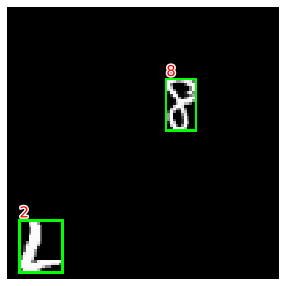

In [3]:
ix = randint(len(trndata))
a,b,c = trndata[ix]
show(a, texts=c, bbs=b, th=1, sz=5)

In [4]:
#imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import models

In [5]:
#anchors
def compute_anchors(anchor_grid, anchor_zooms, anchor_ratios):
    anchor_scales = [(anc*h, anc*w) for anc in anchor_zooms for (h,w) in anchor_ratios]
    anchor_offsets = [1/(2*o) for o in anchor_grid]
    num_boxes = len(anchor_scales)
    anchor_x = [np.repeat(np.linspace(ao, 1-ao, ag), ag) for (ao, ag) in zip(anchor_offsets, anchor_grid)]
    anchor_x = np.concatenate(anchor_x)
    anchor_y = [np.tile(np.linspace(ao, 1-ao, ag), ag) for ao,ag in zip(anchor_offsets, anchor_grid)]
    anchor_y = np.concatenate(anchor_y)
    anchor_centers = np.repeat(np.stack([anchor_x, anchor_y], axis=1), num_boxes, axis=0)

    anchor_sizes  = [np.array([[w/ag, h/ag] for _ in range(ag**2) for w, h in anchor_scales])
                     for ag in anchor_grid]
    anchor_sizes = np.concatenate(anchor_sizes)
    anchors = np.concatenate([anchor_centers, anchor_sizes], axis=1)
    anchors = torch.from_numpy(anchors).float()
    anchors = anchors.to(device)
    return anchors, num_boxes

inspect = lambda ts: print([t.shape if hasattr(t, 'shape') else len(t) for t in ts])

def anc2bb(*x):
    '''convert anchor notation to bb notation (xc,yc,w,h -> x,y,X,Y); works for single box (4 args) or a single tensor of Nx4 shape'''
    if len(x) == 4:
        xc,yc,w,h = x
        return torch.stack([xc-w/2,yc-h/2,xc+w/2,yc+h/2])
    else:
        xc,yc,w,h = x[0].T
        return torch.stack([xc-w/2,yc-h/2,xc+w/2,yc+h/2])


anchor_grid = [4] # Number of grid-elements per dimension
anchor_zooms = [1.0] # How much bigger/smaller each default box will be (percentage)
anchor_ratios = [(1.0, 1.0), (0.5,1.0)] # Ratio between (width, height)
anchor_offsets = [(0,0), (0,0.25)]

anchors, num_boxes = compute_anchors(anchor_grid, anchor_zooms, anchor_ratios)
len(anchors), num_boxes
# Ideally this should be a config : {(4,1,1,0), (4,1,(0.5,1),(0,0.25))} # {(nboxes/gridsize, zoomratios, aspectratios, offsets)} in all cases int implies (int,int)

(32, 2)

In [6]:
dummy = np.ones((1000,1000,3))*255
bbs = []
for anc in anchors:
    bb = BB(anc2bb(anc)*1000)
    bb = bb.jitter(20) if bb.w>200 else bb.jitter(3)
    bbs.append(bb)
show(dummy, bbs=bbs, sz=5, bb_colors='random')

anchor boxes: [26, 27, 28, 29, 0, 1, 30, 31, 24, 25, 14, 15, 2, 3, 18, 19, 6, 7, 20, 21, 10, 11] overlaping with bbs: [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10]


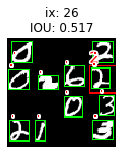

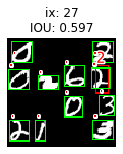

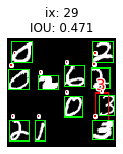

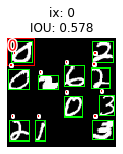

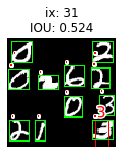

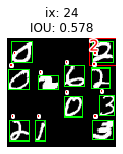

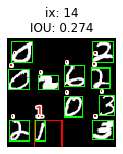

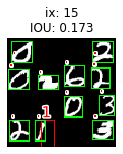

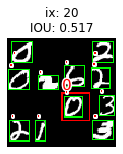

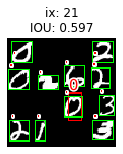

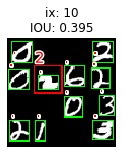

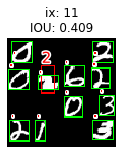

In [7]:
from src.evaluation import jaccard, non_max_suppression, PredBoundingBox, MAP, center_2_hw, intersect
def find_overlap(bbs, anchors, jaccard_overlap):
    jaccard_tensor = jaccard(anchors, bbs, anchors=True)
    _, max_overlap = torch.max(jaccard_tensor, dim=0)
    overlap_list,overlap_bb_ixs = [],[]
    for i in range(len(bbs)):
        threshold_overlap = (jaccard_tensor[:, i] > jaccard_overlap).nonzero()
        overlap_bb_ixs.extend([i]*len(threshold_overlap))
        overlap_list.extend(threshold_overlap.view(-1).cpu().numpy().tolist())
    return overlap_list, overlap_bb_ixs

ix = randint(len(trndata))
a,b,c = trndata[ix]
bb_truth = torch.tensor(b).to(device).float()/100
overlap_ixs, overlap_bb_ixs = find_overlap(bb_truth, anchors, jaccard_overlap = 0.1)
print(f'anchor boxes: {overlap_ixs} overlaping with bbs: {overlap_bb_ixs}')

for kx, jx in enumerate(overlap_ixs):
    bb = anc2bb(anchors[jx])
    jacc = jaccard(bb[None], bb_truth)
    ovp = f'{jacc.max():.3f}'
    texts = c
    bb = bb*100
    show(a, bbs=[bb]+[_b for _b in b], 
         texts = [c[overlap_bb_ixs[kx]]] + ['']*len(b),
         bb_colors=[(255,0,0)]+[(0,255,0)]*len(b), 
         th=1, sz=2, title='ix: {}\nIOU: {}'.format(jx, ovp))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


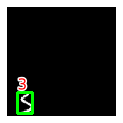

In [8]:
class MNISTLocData(Dataset):
    def __init__(self, data_list_, target_size_=50, train_mode=False):
        self.target_size = target_size_
        self.data_list = data_list_
        self.train_mode = train_mode

    def __len__(self): return len(self.data_list)

    def __getitem__(self, idx):
        img, gt, cls = self.data_list[idx]
        gt = np.array(gt)
        
        img = torch.from_numpy(img[None]).float() / 255.
        gt = torch.from_numpy(gt).float() / self.target_size
        gt = gt.to(device)

        c = torch.from_numpy(np.array(cls)) + 1
        c = c.to(device)
        (img, gt, c) = map(lambda x: x.to(device), (img, gt, c))
        # >>> inspect([img, gt, c])
        # [torch.Size([1, 100, 100]), torch.Size([1, N_IMGS, 4]), torch.Size([1, N_IMGS])]
        return (img, gt, c)

def collate_fn(batch):
    """
    Writing custom collector function since the Dataset class returns both tensors and lists.
    """
    x = [b[0] for b in batch]
    x = torch.stack(x, dim=0)
    bbs = [b[1] for b in batch]
    c = [b[2] for b in batch]
    return (x, bbs, c)

x = DataLoader(MNISTLocData(trndata[:161]), batch_size=32, shuffle=True, collate_fn=collate_fn)
ims, bbs, labels = next(iter(x))
ix = randint(32)
show(ims[ix,0], bbs=((50*bbs[ix]).type(torch.int)).cpu().numpy().tolist(), texts=(labels[ix]-1).cpu().numpy().tolist())

In [9]:
class StandardConv(nn.Module):
    def __init__(self, in_channels, out_channels, p, stride=2):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(p=p)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        return x
    
class OutputConv(nn.Module):
    def __init__(self, in_channels, num_boxes):
        super().__init__()
        self.num_boxes = num_boxes
        self.conv_1 = nn.Conv2d(in_channels, (len(id_cat) + 1) * self.num_boxes, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv2d(in_channels, 4 * self.num_boxes, kernel_size=3, padding=1)

    def flatten_conv(self, x):
        samples, channels, _, _ = x.size()
        x = x.permute(0, 2, 3, 1).contiguous()
        return x.view(samples, -1, int(channels / self.num_boxes))

    def forward(self, x):
        # [class predictions, box coordinates]
        return [self.flatten_conv(self.conv_1(x)), 
                self.flatten_conv(self.conv_2(x))]
    
class Model(nn.Module):
    def __init__(self, num_boxes=num_boxes, p=[0.2,0.2]):
        super().__init__()

        self.backbone = nn.Sequential(
            StandardConv(1, 64, p[1], stride=1),
            StandardConv(64, 64, p[1], stride=2),
            StandardConv(64, 64, p[1], stride=2),
            StandardConv(64, 256, p[1], stride=2),
            StandardConv(256, 256, p[1], stride=2),
        )
        self.backbone_dropout = nn.Dropout2d(p=p[0])

        self.std_conv = nn.ModuleList([
            StandardConv(256, 256, p[1], stride=2),
        ])
        self.out_conv = nn.ModuleList([
            OutputConv(256, num_boxes),
            OutputConv(256, 8),
        ])

    def forward(self, x):
        x = self.backbone(x)
        x = self.backbone_dropout(x)
        
        x = self.std_conv[0](x)
        output_class_0, output_bb_0 = self.out_conv[0](x)
        
        # x = self.std_conv[1](x)
        # output_class_1, output_bb_1 = self.out_conv[1](x)
        
        # return [torch.cat([output_class_0, output_class_1], dim=1),
        #         torch.cat([output_bb_0, output_bb_1], dim=1)]
        return [torch.cat([output_class_0], dim=1), torch.sigmoid(torch.cat([output_bb_0], dim=1))]
    
    def change_freezing(self, mode=False):
        for param in self.backbone.parameters():
            param.requires_grad = mode
    def train(self, mode=True):
        super().train(mode)
        # Avoid updating BN stats
        for m in self.backbone.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()

from torchsummary import summary
summary(Model(), input_size=(1,100,100), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]             576
       BatchNorm2d-2         [-1, 64, 100, 100]             128
         Dropout2d-3         [-1, 64, 100, 100]               0
      StandardConv-4         [-1, 64, 100, 100]               0
            Conv2d-5           [-1, 64, 50, 50]          36,864
       BatchNorm2d-6           [-1, 64, 50, 50]             128
         Dropout2d-7           [-1, 64, 50, 50]               0
      StandardConv-8           [-1, 64, 50, 50]               0
            Conv2d-9           [-1, 64, 25, 25]          36,864
      BatchNorm2d-10           [-1, 64, 25, 25]             128
        Dropout2d-11           [-1, 64, 25, 25]               0
     StandardConv-12           [-1, 64, 25, 25]               0
           Conv2d-13          [-1, 256, 13, 13]         147,456
      BatchNorm2d-14          [-1, 256,

In [10]:
from src.evaluation import jaccard, non_max_suppression, PredBoundingBox, MAP, center_2_hw

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, eps=1e-10):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps

    def forward_deprecated(self, input, target):
        p = torch.sigmoid(input)
        pt = p * target.float() + (1.0 - p) * (1 - target).float()
        alpha_t = (1.0 - self.alpha) * target.float() + self.alpha * (1 - target).float()
        loss = - 1.0 * torch.pow((1 - pt), self.gamma) * torch.log(pt + self.eps)
        return loss.sum()
    
    def forward(self, input, target):
        p = torch.nn.functional.softmax(input, dim=-1)
        pt = p * target.float() + (1.0 - p) * (1 - target).float()
        alpha_t = (1.0 - self.alpha) * target.float() + self.alpha * (1 - target).float()
        loss = - 1.0 * torch.pow((1 - pt), self.gamma) * torch.log(pt + self.eps)
        return loss.sum()

class SSDLoss(nn.Module):
    def __init__(self, loc_factor, anchors, jaccard_overlap, **kwargs):
        super().__init__()
        self.fl = FocalLoss(**kwargs)
        self.loc_factor = loc_factor
        self.jaccard_overlap = jaccard_overlap
        self.anchors = anchors

    @staticmethod
    def one_hot_encoding(labels, num_class_turths):
        return torch.eye(num_class_turths)[labels]

    @staticmethod
    def loc_transformation(x, anchors, overlap_indicies):
        # Doing location transformations according to SSD paper
        return torch.cat([(x[:, 0:1] - anchors[overlap_indicies, 0:1]) / anchors[overlap_indicies, 2:3],
                          (x[:, 1:2] - anchors[overlap_indicies, 1:2]) / anchors[overlap_indicies, 3:4],
                          torch.log((x[:, 2:3] / anchors[overlap_indicies, 2:3])),
                          torch.log((x[:, 3:4] / anchors[overlap_indicies, 3:4]))
                         ], dim=1)

    def forward(self, class_hat, bb_hat, class_turths, bbs):
        batch_size = len(class_hat)
        loc_loss = 0.0
        class_loss = 0.0
        # print([t.shape if isinstance(t,torch.Tensor) else [t[0].shape] for t in [class_hat, bb_hat, class_turths, bbs]])
        
        for i in range(batch_size):
            _bbs = bbs[i]
            temp_loc_loss = torch.tensor(0.0, requires_grad=False, device=device)
            class_target = torch.zeros(len(class_hat[i]),).long().to(device)
            
            overlap_list, overlap_bb_ixs = find_overlap(_bbs, self.anchors, self.jaccard_overlap)
            # print(f'anchor boxes: {overlap_list} overlaping with bbs: {overlap_bb_ixs}')
            assert len(overlap_bb_ixs) == len(overlap_list)
            _bbs = [anc2bb(anchors[jx]*100).cpu().type(torch.int).numpy().tolist() for jx in overlap_list]
            
            # show(ims[i,0], bbs=_bbs)
            for j in range(len(overlap_list)):  # BB level
                overlap_anchor_box_ix = overlap_list[j]
                overlap_gtbb_ix = overlap_bb_ixs[j]
                class_target[overlap_anchor_box_ix] = class_turths[i][overlap_gtbb_ix]
                bb_hat_at_ix_anchor = bb_hat[i, overlap_anchor_box_ix]
                # print(f'anchor #: {overlap_anchor_box_ix}, overlapping with bb #: {overlap_gtbb_ix}')
                target_ = self.loc_transformation(bbs[i][overlap_gtbb_ix].expand((1, 4)), self.anchors, overlap_anchor_box_ix)[0]
                # print(target_, bb_hat_at_ix_anchor)
                temp_loc_loss += F.smooth_l1_loss(input=bb_hat_at_ix_anchor, target=target_, reduction="sum") / 1
            loc_loss += temp_loc_loss / len(class_turths[i])
            class_target = SSDLoss.one_hot_encoding(class_target, len(id_cat) + 1).float().to(device)
            class_loss += self.fl(class_hat[i], class_target) / len(class_turths)
        loc_loss = loc_loss / len(class_turths)
        class_loss = class_loss / len(class_turths)
        loss = class_loss + loc_loss * self.loc_factor
        return loss, loc_loss, class_loss

In [11]:
inspect = lambda ts: print([t.shape if hasattr(t, 'shape') else f'{type(t)}: {len(t)} items' for t in ts])
model = Model().to(device)
dataset = MNISTLocData(trndata[:20], target_size_=100)
trn_dl = DataLoader(dataset, batch_size=2, collate_fn=collate_fn, shuffle=True)

IO = ims,bbs,classes = next(iter(trn_dl))
inspect(IO)
class_hat, bb_hat = pred = model(ims.to(device))
print([t.shape for t in pred])

jaccard_threshold = 0.1
loss = SSDLoss(loc_factor=10, anchors=anchors, jaccard_overlap=jaccard_threshold)
batch_loss, batch_loc, batch_class = loss(class_hat, bb_hat, classes, bbs)
map_eval = MAP(model, dataset, jaccard_threshold, anchors)
_, mAP = map_eval()
mAP = np.round(mAP, 6)
mAP


[torch.Size([2, 1, 100, 100]), "<class 'list'>: 2 items", "<class 'list'>: 2 items"]
[torch.Size([2, 32, 11]), torch.Size([2, 32, 4])]


0.01875

In [12]:
# train
model = Model().to(device)
dataset = MNISTLocData(trndata[:100])
trn_dl = DataLoader(dataset, batch_size=64, collate_fn=collate_fn, shuffle=True)

dataset = MNISTLocData(valdata[:100])
val_dl = DataLoader(dataset, batch_size=64, collate_fn=collate_fn)

loss = SSDLoss(loc_factor=5, anchors=anchors, jaccard_overlap=0.1)
n_epochs = 4000
lr = 1e-3
wd = 1e-2

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=wd)
jaccard_threshold = 0.5
map_eval = MAP(model, MNISTLocData(trndata[:100]), jaccard_threshold, anchors)

import random
torch.manual_seed(10)
random.seed(10)
for epoch in range(n_epochs+1):
    model.train()

    train_loss, train_loc_loss, train_class_loss  = 0.0, 0.0, 0.0
    for _, (x, bb_true, class_true) in enumerate(trn_dl):
        model.zero_grad()
        class_hat, bb_hat = model(x)

        batch_loss, batch_loc, batch_class = loss(class_hat, bb_hat, class_true, bb_true)
        batch_loss.backward()
        optimizer.step()

        train_loss += batch_loss.detach().cpu().numpy()
        train_class_loss += batch_class.detach().cpu().numpy()
        train_loc_loss += batch_loc.detach().cpu().numpy()

    train_loss =  np.round(train_loss / len(trn_dl), 6)
    train_loc_loss =  np.round(train_loc_loss / len(trn_dl), 6)
    train_class_loss =  np.round(train_class_loss / len(trn_dl), 6)

    with torch.no_grad():
        val_loss, val_loc_loss, val_class_loss = 0.0, 0.0, 0.0
        for _, (x, bb_true, class_true) in enumerate(val_dl):
            class_hat, bb_hat = model(x)
            batch_loss, batch_loc, batch_class = loss(class_hat, bb_hat, class_true, bb_true)
            val_loss += batch_loss.detach().cpu().numpy()
            val_loc_loss += batch_loc.detach().cpu().numpy()
            val_class_loss += batch_class.detach().cpu().numpy()
        val_loss = np.round(val_loss / len(val_dl), 6)
        val_loc_loss = np.round(val_loc_loss / len(val_dl), 6)
        val_class_loss = np.round(val_class_loss / len(val_dl), 6)

        _, mAP = map_eval()
        mAP = np.round(mAP, 6)

    if epoch % 1 == 0:
        print(f"----- Epoch {epoch} -----")
        print(f"Train loss: {train_loss}")
        print(f"Train loc loss: {train_loc_loss}")
        print(f"Train class loss: {train_class_loss}")
        if 1:
            print(f"Val loss: {val_loss}")
            print(f"Val loc loss: {val_loc_loss}")
            print(f"Val class loss: {val_class_loss}")
            print(f"Val mAP: {mAP}")
            torch.save(model, 'model.2.1.pth')


----- Epoch 0 -----
Train loss: 15.284063
Train loc loss: 2.826604
Train class loss: 1.151046
Val loss: 10.853315
Val loc loss: 1.991762
Val class loss: 0.894505
Val mAP: 0.0


/home/yyr/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/yyr/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/yyr/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type StandardConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/yyr/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't 

----- Epoch 1 -----
Train loss: 11.018928
Train loc loss: 2.017298
Train class loss: 0.932436
Val loss: 9.148999
Val loc loss: 1.66662
Val class loss: 0.8159
Val mAP: 0.0
----- Epoch 2 -----
Train loss: 9.265699
Train loc loss: 1.701235
Train class loss: 0.759524
Val loss: 8.542812
Val loc loss: 1.559057
Val class loss: 0.747525
Val mAP: 0.0
----- Epoch 3 -----
Train loss: 8.771782
Train loc loss: 1.611148
Train class loss: 0.716044
Val loss: 8.322734
Val loc loss: 1.513209
Val class loss: 0.756689
Val mAP: 0.0
----- Epoch 4 -----
Train loss: 8.288131
Train loc loss: 1.526373
Train class loss: 0.656264
Val loss: 8.146473
Val loc loss: 1.484033
Val class loss: 0.726308
Val mAP: 0.0
----- Epoch 5 -----
Train loss: 8.361061
Train loc loss: 1.544606
Train class loss: 0.638032
Val loss: 8.082632
Val loc loss: 1.471157
Val class loss: 0.726848
Val mAP: 0.0
----- Epoch 6 -----
Train loss: 8.247421
Train loc loss: 1.520867
Train class loss: 0.643084
Val loss: 8.02019
Val loc loss: 1.45868
Val 

----- Epoch 48 -----
Train loss: 7.796757
Train loc loss: 1.474268
Train class loss: 0.425417
Val loss: 7.879618
Val loc loss: 1.426582
Val class loss: 0.746707
Val mAP: 0.015184
----- Epoch 49 -----
Train loss: 7.566093
Train loc loss: 1.439021
Train class loss: 0.37099
Val loss: 7.881486
Val loc loss: 1.425007
Val class loss: 0.756451
Val mAP: 0.018289
----- Epoch 50 -----
Train loss: 7.768068
Train loc loss: 1.474884
Train class loss: 0.393649
Val loss: 7.871986
Val loc loss: 1.425242
Val class loss: 0.745778
Val mAP: 0.016146
----- Epoch 51 -----
Train loss: 7.573781
Train loc loss: 1.441121
Train class loss: 0.368178
Val loss: 7.872553
Val loc loss: 1.426212
Val class loss: 0.74149
Val mAP: 0.017355
----- Epoch 52 -----
Train loss: 7.715519
Train loc loss: 1.468988
Train class loss: 0.370579
Val loss: 7.890994
Val loc loss: 1.426232
Val class loss: 0.759836
Val mAP: 0.016536
----- Epoch 53 -----
Train loss: 7.462596
Train loc loss: 1.41981
Train class loss: 0.363546
Val loss: 7.87

----- Epoch 94 -----
Train loss: 7.577335
Train loc loss: 1.502815
Train class loss: 0.063261
Val loss: 8.08185
Val loc loss: 1.425866
Val class loss: 0.952519
Val mAP: 0.053895
----- Epoch 95 -----
Train loss: 7.603393
Train loc loss: 1.508328
Train class loss: 0.061752
Val loss: 8.095512
Val loc loss: 1.4273
Val class loss: 0.959012
Val mAP: 0.055411
----- Epoch 96 -----
Train loss: 7.23347
Train loc loss: 1.436994
Train class loss: 0.048499
Val loss: 8.096067
Val loc loss: 1.427767
Val class loss: 0.957234
Val mAP: 0.055411
----- Epoch 97 -----
Train loss: 7.269858
Train loc loss: 1.444002
Train class loss: 0.049849
Val loss: 8.070325
Val loc loss: 1.425565
Val class loss: 0.942502
Val mAP: 0.053895
----- Epoch 98 -----
Train loss: 7.47463
Train loc loss: 1.483649
Train class loss: 0.056383
Val loss: 8.146377
Val loc loss: 1.427678
Val class loss: 1.007984
Val mAP: 0.053895
----- Epoch 99 -----
Train loss: 7.347784
Train loc loss: 1.459803
Train class loss: 0.048768
Val loss: 8.1231

----- Epoch 140 -----
Train loss: 7.43791
Train loc loss: 1.484194
Train class loss: 0.016942
Val loss: 8.256133
Val loc loss: 1.425178
Val class loss: 1.130242
Val mAP: 0.059917
----- Epoch 141 -----
Train loss: 7.371313
Train loc loss: 1.47057
Train class loss: 0.018462
Val loss: 8.227413
Val loc loss: 1.424522
Val class loss: 1.104805
Val mAP: 0.059917
----- Epoch 142 -----
Train loss: 6.939778
Train loc loss: 1.385093
Train class loss: 0.014314
Val loss: 8.248712
Val loc loss: 1.426137
Val class loss: 1.118026
Val mAP: 0.054764
----- Epoch 143 -----
Train loss: 7.228587
Train loc loss: 1.441976
Train class loss: 0.018709
Val loss: 8.280154
Val loc loss: 1.424668
Val class loss: 1.156815
Val mAP: 0.058222
----- Epoch 144 -----
Train loss: 7.434564
Train loc loss: 1.483717
Train class loss: 0.015977
Val loss: 8.302485
Val loc loss: 1.42489
Val class loss: 1.178034
Val mAP: 0.056582
----- Epoch 145 -----
Train loss: 7.628736
Train loc loss: 1.522659
Train class loss: 0.015442
Val loss

----- Epoch 186 -----
Train loss: 6.984906
Train loc loss: 1.395383
Train class loss: 0.007991
Val loss: 8.30039
Val loc loss: 1.423424
Val class loss: 1.183272
Val mAP: 0.058277
----- Epoch 187 -----
Train loss: 7.611069
Train loc loss: 1.519783
Train class loss: 0.012153
Val loss: 8.35041
Val loc loss: 1.423592
Val class loss: 1.232452
Val mAP: 0.059917
----- Epoch 188 -----
Train loss: 7.084098
Train loc loss: 1.414926
Train class loss: 0.009468
Val loss: 8.37118
Val loc loss: 1.425347
Val class loss: 1.244443
Val mAP: 0.058222
----- Epoch 189 -----
Train loss: 7.386215
Train loc loss: 1.475349
Train class loss: 0.00947
Val loss: 8.358865
Val loc loss: 1.423793
Val class loss: 1.2399
Val mAP: 0.058277
----- Epoch 190 -----
Train loss: 7.309359
Train loc loss: 1.460229
Train class loss: 0.008216
Val loss: 8.337292
Val loc loss: 1.423791
Val class loss: 1.21834
Val mAP: 0.056849
----- Epoch 191 -----
Train loss: 7.475733
Train loc loss: 1.492758
Train class loss: 0.011941
Val loss: 8.

----- Epoch 232 -----
Train loss: 7.66357
Train loc loss: 1.530564
Train class loss: 0.010749
Val loss: 8.386665
Val loc loss: 1.423704
Val class loss: 1.268145
Val mAP: 0.059917
----- Epoch 233 -----
Train loss: 7.429802
Train loc loss: 1.483934
Train class loss: 0.010134
Val loss: 8.396401
Val loc loss: 1.423698
Val class loss: 1.277912
Val mAP: 0.058222
----- Epoch 234 -----
Train loss: 7.504301
Train loc loss: 1.498779
Train class loss: 0.010404
Val loss: 8.398732
Val loc loss: 1.423164
Val class loss: 1.282914
Val mAP: 0.059917
----- Epoch 235 -----
Train loss: 7.674786
Train loc loss: 1.533156
Train class loss: 0.009005
Val loss: 8.418763
Val loc loss: 1.422364
Val class loss: 1.306945
Val mAP: 0.059917
----- Epoch 236 -----
Train loss: 7.662346
Train loc loss: 1.530546
Train class loss: 0.009615
Val loss: 8.400335
Val loc loss: 1.423708
Val class loss: 1.281797
Val mAP: 0.056582
----- Epoch 237 -----
Train loss: 7.474532
Train loc loss: 1.493488
Train class loss: 0.007091
Val lo

----- Epoch 278 -----
Train loss: 7.224877
Train loc loss: 1.444057
Train class loss: 0.004594
Val loss: 8.410406
Val loc loss: 1.42152
Val class loss: 1.302803
Val mAP: 0.056582
----- Epoch 279 -----
Train loss: 7.476789
Train loc loss: 1.494483
Train class loss: 0.004372
Val loss: 8.410404
Val loc loss: 1.422602
Val class loss: 1.297396
Val mAP: 0.059917
----- Epoch 280 -----
Train loss: 7.394186
Train loc loss: 1.476708
Train class loss: 0.010648
Val loss: 8.441184
Val loc loss: 1.422207
Val class loss: 1.330147
Val mAP: 0.059917
----- Epoch 281 -----
Train loss: 7.300981
Train loc loss: 1.458704
Train class loss: 0.007463
Val loss: 8.458753
Val loc loss: 1.422278
Val class loss: 1.347364
Val mAP: 0.059917
----- Epoch 282 -----
Train loss: 7.195467
Train loc loss: 1.438012
Train class loss: 0.005405
Val loss: 8.43046
Val loc loss: 1.423669
Val class loss: 1.312117
Val mAP: 0.059917
----- Epoch 283 -----
Train loss: 7.23444
Train loc loss: 1.445768
Train class loss: 0.005599
Val loss

----- Epoch 324 -----
Train loss: 7.421403
Train loc loss: 1.483319
Train class loss: 0.004811
Val loss: 8.473702
Val loc loss: 1.421795
Val class loss: 1.364729
Val mAP: 0.058222
----- Epoch 325 -----
Train loss: 7.352785
Train loc loss: 1.469197
Train class loss: 0.006799
Val loss: 8.500954
Val loc loss: 1.421943
Val class loss: 1.39124
Val mAP: 0.058222
----- Epoch 326 -----
Train loss: 7.251968
Train loc loss: 1.449652
Train class loss: 0.003709
Val loss: 8.527628
Val loc loss: 1.421937
Val class loss: 1.417942
Val mAP: 0.056527
----- Epoch 327 -----
Train loss: 7.621727
Train loc loss: 1.523015
Train class loss: 0.00665
Val loss: 8.47095
Val loc loss: 1.421597
Val class loss: 1.362963
Val mAP: 0.058222
----- Epoch 328 -----
Train loss: 7.303173
Train loc loss: 1.459632
Train class loss: 0.005012
Val loss: 8.535885
Val loc loss: 1.422198
Val class loss: 1.424896
Val mAP: 0.059917
----- Epoch 329 -----
Train loss: 7.335826
Train loc loss: 1.465659
Train class loss: 0.007533
Val loss

----- Epoch 370 -----
Train loss: 7.63285
Train loc loss: 1.525452
Train class loss: 0.005592
Val loss: 8.471029
Val loc loss: 1.421308
Val class loss: 1.364492
Val mAP: 0.059917
----- Epoch 371 -----
Train loss: 7.44167
Train loc loss: 1.487168
Train class loss: 0.005829
Val loss: 8.530374
Val loc loss: 1.422328
Val class loss: 1.418732
Val mAP: 0.058329
----- Epoch 372 -----
Train loss: 7.304557
Train loc loss: 1.459739
Train class loss: 0.005863
Val loss: 8.497253
Val loc loss: 1.422116
Val class loss: 1.386675
Val mAP: 0.059917
----- Epoch 373 -----
Train loss: 7.353147
Train loc loss: 1.469368
Train class loss: 0.006307
Val loss: 8.492036
Val loc loss: 1.422622
Val class loss: 1.378925
Val mAP: 0.059917
----- Epoch 374 -----
Train loss: 7.452267
Train loc loss: 1.489503
Train class loss: 0.004751
Val loss: 8.496944
Val loc loss: 1.421551
Val class loss: 1.389189
Val mAP: 0.058488
----- Epoch 375 -----
Train loss: 7.529248
Train loc loss: 1.505048
Train class loss: 0.00401
Val loss

----- Epoch 416 -----
Train loss: 7.674171
Train loc loss: 1.533457
Train class loss: 0.006886
Val loss: 8.511019
Val loc loss: 1.421098
Val class loss: 1.405528
Val mAP: 0.058222
----- Epoch 417 -----
Train loss: 7.377604
Train loc loss: 1.474519
Train class loss: 0.00501
Val loss: 8.500947
Val loc loss: 1.420755
Val class loss: 1.39717
Val mAP: 0.059917
----- Epoch 418 -----
Train loss: 7.311943
Train loc loss: 1.461211
Train class loss: 0.005886
Val loss: 8.536511
Val loc loss: 1.421492
Val class loss: 1.429052
Val mAP: 0.059917
----- Epoch 419 -----
Train loss: 7.463142
Train loc loss: 1.491549
Train class loss: 0.005398
Val loss: 8.535575
Val loc loss: 1.420813
Val class loss: 1.43151
Val mAP: 0.059917
----- Epoch 420 -----
Train loss: 7.560515
Train loc loss: 1.510964
Train class loss: 0.005697
Val loss: 8.551778
Val loc loss: 1.420809
Val class loss: 1.447734
Val mAP: 0.058277
----- Epoch 421 -----
Train loss: 7.217393
Train loc loss: 1.44218
Train class loss: 0.006492
Val loss:

----- Epoch 462 -----
Train loss: 7.482427
Train loc loss: 1.495181
Train class loss: 0.006521
Val loss: 8.529236
Val loc loss: 1.421286
Val class loss: 1.422804
Val mAP: 0.059917
----- Epoch 463 -----
Train loss: 7.445569
Train loc loss: 1.488137
Train class loss: 0.004882
Val loss: 8.571163
Val loc loss: 1.421732
Val class loss: 1.462501
Val mAP: 0.059917
----- Epoch 464 -----
Train loss: 6.894138
Train loc loss: 1.378046
Train class loss: 0.003907
Val loss: 8.579342
Val loc loss: 1.421764
Val class loss: 1.470521
Val mAP: 0.059917
----- Epoch 465 -----
Train loss: 7.408037
Train loc loss: 1.480534
Train class loss: 0.005364
Val loss: 8.578479
Val loc loss: 1.420873
Val class loss: 1.474116
Val mAP: 0.059917
----- Epoch 466 -----
Train loss: 7.164293
Train loc loss: 1.431983
Train class loss: 0.004378
Val loss: 8.570647
Val loc loss: 1.420902
Val class loss: 1.466139
Val mAP: 0.059917
----- Epoch 467 -----
Train loss: 7.066184
Train loc loss: 1.412381
Train class loss: 0.00428
Val lo

----- Epoch 508 -----
Train loss: 7.305986
Train loc loss: 1.460299
Train class loss: 0.004492
Val loss: 8.57822
Val loc loss: 1.420552
Val class loss: 1.475461
Val mAP: 0.059917
----- Epoch 509 -----
Train loss: 7.50674
Train loc loss: 1.500846
Train class loss: 0.002512
Val loss: 8.52657
Val loc loss: 1.421411
Val class loss: 1.419515
Val mAP: 0.059917
----- Epoch 510 -----
Train loss: 7.894055
Train loc loss: 1.577887
Train class loss: 0.004622
Val loss: 8.551509
Val loc loss: 1.421144
Val class loss: 1.445787
Val mAP: 0.059917
----- Epoch 511 -----
Train loss: 7.250182
Train loc loss: 1.449461
Train class loss: 0.00288
Val loss: 8.533002
Val loc loss: 1.420962
Val class loss: 1.42819
Val mAP: 0.058222
----- Epoch 512 -----
Train loss: 7.154518
Train loc loss: 1.430414
Train class loss: 0.002447
Val loss: 8.539159
Val loc loss: 1.421136
Val class loss: 1.433481
Val mAP: 0.059917
----- Epoch 513 -----
Train loss: 7.478848
Train loc loss: 1.493961
Train class loss: 0.009042
Val loss: 

----- Epoch 554 -----
Train loss: 7.504929
Train loc loss: 1.499692
Train class loss: 0.006471
Val loss: 8.627239
Val loc loss: 1.421477
Val class loss: 1.519856
Val mAP: 0.059917
----- Epoch 555 -----
Train loss: 7.605642
Train loc loss: 1.519723
Train class loss: 0.007029
Val loss: 8.605134
Val loc loss: 1.420764
Val class loss: 1.501317
Val mAP: 0.058277
----- Epoch 556 -----
Train loss: 7.664765
Train loc loss: 1.531772
Train class loss: 0.005905
Val loss: 8.574097
Val loc loss: 1.421903
Val class loss: 1.46458
Val mAP: 0.059917
----- Epoch 557 -----
Train loss: 7.164906
Train loc loss: 1.432
Train class loss: 0.004909
Val loss: 8.587368
Val loc loss: 1.421892
Val class loss: 1.477906
Val mAP: 0.058277
----- Epoch 558 -----
Train loss: 7.302736
Train loc loss: 1.459907
Train class loss: 0.003198
Val loss: 8.602936
Val loc loss: 1.421807
Val class loss: 1.493903
Val mAP: 0.056582
----- Epoch 559 -----
Train loss: 7.711064
Train loc loss: 1.540988
Train class loss: 0.006124
Val loss:

----- Epoch 600 -----
Train loss: 7.336515
Train loc loss: 1.466382
Train class loss: 0.004603
Val loss: 8.629119
Val loc loss: 1.421226
Val class loss: 1.522991
Val mAP: 0.059917
----- Epoch 601 -----
Train loss: 7.738737
Train loc loss: 1.546873
Train class loss: 0.00437
Val loss: 8.593937
Val loc loss: 1.421099
Val class loss: 1.488442
Val mAP: 0.059917
----- Epoch 602 -----
Train loss: 7.126754
Train loc loss: 1.42433
Train class loss: 0.005106
Val loss: 8.55337
Val loc loss: 1.420675
Val class loss: 1.449995
Val mAP: 0.059917
----- Epoch 603 -----
Train loss: 7.495354
Train loc loss: 1.497905
Train class loss: 0.005828
Val loss: 8.585579
Val loc loss: 1.42097
Val class loss: 1.480727
Val mAP: 0.056582
----- Epoch 604 -----
Train loss: 7.395009
Train loc loss: 1.478265
Train class loss: 0.003686
Val loss: 8.552483
Val loc loss: 1.41976
Val class loss: 1.453685
Val mAP: 0.056582
----- Epoch 605 -----
Train loss: 7.107093
Train loc loss: 1.420744
Train class loss: 0.003376
Val loss: 

----- Epoch 646 -----
Train loss: 7.732335
Train loc loss: 1.545384
Train class loss: 0.005415
Val loss: 8.612069
Val loc loss: 1.420318
Val class loss: 1.510479
Val mAP: 0.059917
----- Epoch 647 -----
Train loss: 7.547782
Train loc loss: 1.50874
Train class loss: 0.00408
Val loss: 8.606862
Val loc loss: 1.42061
Val class loss: 1.503811
Val mAP: 0.059917
----- Epoch 648 -----
Train loss: 7.240587
Train loc loss: 1.446885
Train class loss: 0.006163
Val loss: 8.633733
Val loc loss: 1.420586
Val class loss: 1.530803
Val mAP: 0.056582
----- Epoch 649 -----
Train loss: 7.258153
Train loc loss: 1.450705
Train class loss: 0.004631
Val loss: 8.585399
Val loc loss: 1.420237
Val class loss: 1.484214
Val mAP: 0.058222
----- Epoch 650 -----
Train loss: 7.409048
Train loc loss: 1.481203
Train class loss: 0.003032
Val loss: 8.563476
Val loc loss: 1.42143
Val class loss: 1.456326
Val mAP: 0.061215
----- Epoch 651 -----
Train loss: 7.30108
Train loc loss: 1.459484
Train class loss: 0.00366
Val loss: 8

----- Epoch 692 -----
Train loss: 7.559505
Train loc loss: 1.511294
Train class loss: 0.003035
Val loss: 8.622847
Val loc loss: 1.421221
Val class loss: 1.516739
Val mAP: 0.059917
----- Epoch 693 -----
Train loss: 7.10795
Train loc loss: 1.420986
Train class loss: 0.003018
Val loss: 8.628691
Val loc loss: 1.421983
Val class loss: 1.518779
Val mAP: 0.059917
----- Epoch 694 -----
Train loss: 7.446368
Train loc loss: 1.488419
Train class loss: 0.004273
Val loss: 8.590018
Val loc loss: 1.421199
Val class loss: 1.484025
Val mAP: 0.059917
----- Epoch 695 -----
Train loss: 7.289437
Train loc loss: 1.456925
Train class loss: 0.004812
Val loss: 8.583912
Val loc loss: 1.420846
Val class loss: 1.479682
Val mAP: 0.059917
----- Epoch 696 -----
Train loss: 7.57468
Train loc loss: 1.514209
Train class loss: 0.003636
Val loss: 8.594595
Val loc loss: 1.422204
Val class loss: 1.483573
Val mAP: 0.059917
----- Epoch 697 -----
Train loss: 7.350773
Train loc loss: 1.469292
Train class loss: 0.004311
Val los

----- Epoch 738 -----
Train loss: 7.263918
Train loc loss: 1.451959
Train class loss: 0.004126
Val loss: 8.616632
Val loc loss: 1.420747
Val class loss: 1.512897
Val mAP: 0.059917
----- Epoch 739 -----
Train loss: 7.4461
Train loc loss: 1.488349
Train class loss: 0.004356
Val loss: 8.574982
Val loc loss: 1.420511
Val class loss: 1.472426
Val mAP: 0.059917
----- Epoch 740 -----
Train loss: 7.325394
Train loc loss: 1.464042
Train class loss: 0.005183
Val loss: 8.677872
Val loc loss: 1.421068
Val class loss: 1.572533
Val mAP: 0.059917
----- Epoch 741 -----
Train loss: 7.483897
Train loc loss: 1.495672
Train class loss: 0.005537
Val loss: 8.614902
Val loc loss: 1.420786
Val class loss: 1.510973
Val mAP: 0.059917
----- Epoch 742 -----
Train loss: 7.158403
Train loc loss: 1.430868
Train class loss: 0.004063
Val loss: 8.608449
Val loc loss: 1.420632
Val class loss: 1.50529
Val mAP: 0.058277
----- Epoch 743 -----
Train loss: 7.387075
Train loc loss: 1.476306
Train class loss: 0.005546
Val loss

----- Epoch 784 -----
Train loss: 7.253466
Train loc loss: 1.449842
Train class loss: 0.004258
Val loss: 8.586163
Val loc loss: 1.421288
Val class loss: 1.479721
Val mAP: 0.058222
----- Epoch 785 -----
Train loss: 7.180008
Train loc loss: 1.435434
Train class loss: 0.002838
Val loss: 8.646572
Val loc loss: 1.420247
Val class loss: 1.545337
Val mAP: 0.059917
----- Epoch 786 -----
Train loss: 7.253338
Train loc loss: 1.450113
Train class loss: 0.002774
Val loss: 8.661361
Val loc loss: 1.420439
Val class loss: 1.559167
Val mAP: 0.059917
----- Epoch 787 -----
Train loss: 7.699662
Train loc loss: 1.538922
Train class loss: 0.005054
Val loss: 8.660762
Val loc loss: 1.420827
Val class loss: 1.556625
Val mAP: 0.059917
----- Epoch 788 -----
Train loss: 7.079889
Train loc loss: 1.415358
Train class loss: 0.003099
Val loss: 8.670613
Val loc loss: 1.420404
Val class loss: 1.568593
Val mAP: 0.059917
----- Epoch 789 -----
Train loss: 7.434928
Train loc loss: 1.486256
Train class loss: 0.00365
Val lo

----- Epoch 830 -----
Train loss: 6.953978
Train loc loss: 1.389809
Train class loss: 0.004933
Val loss: 8.693217
Val loc loss: 1.420881
Val class loss: 1.588811
Val mAP: 0.058222
----- Epoch 831 -----
Train loss: 7.198925
Train loc loss: 1.439187
Train class loss: 0.002991
Val loss: 8.7255
Val loc loss: 1.421266
Val class loss: 1.619168
Val mAP: 0.058222
----- Epoch 832 -----
Train loss: 7.444594
Train loc loss: 1.488173
Train class loss: 0.003728
Val loss: 8.676101
Val loc loss: 1.420237
Val class loss: 1.574915
Val mAP: 0.058222
----- Epoch 833 -----
Train loss: 7.221361
Train loc loss: 1.443687
Train class loss: 0.002925
Val loss: 8.686687
Val loc loss: 1.420633
Val class loss: 1.583522
Val mAP: 0.058222
----- Epoch 834 -----
Train loss: 7.320927
Train loc loss: 1.463114
Train class loss: 0.005355
Val loss: 8.687432
Val loc loss: 1.420685
Val class loss: 1.584007
Val mAP: 0.058222
----- Epoch 835 -----
Train loss: 7.47245
Train loc loss: 1.493467
Train class loss: 0.005114
Val loss

----- Epoch 876 -----
Train loss: 7.188275
Train loc loss: 1.436828
Train class loss: 0.004134
Val loss: 8.701228
Val loc loss: 1.420692
Val class loss: 1.597768
Val mAP: 0.059917
----- Epoch 877 -----
Train loss: 6.999307
Train loc loss: 1.399132
Train class loss: 0.003645
Val loss: 8.680667
Val loc loss: 1.421156
Val class loss: 1.574889
Val mAP: 0.059917
----- Epoch 878 -----
Train loss: 7.256393
Train loc loss: 1.450532
Train class loss: 0.003735
Val loss: 8.696283
Val loc loss: 1.420451
Val class loss: 1.594029
Val mAP: 0.059917
----- Epoch 879 -----
Train loss: 7.571917
Train loc loss: 1.513306
Train class loss: 0.005385
Val loss: 8.724731
Val loc loss: 1.421346
Val class loss: 1.618003
Val mAP: 0.059917
----- Epoch 880 -----
Train loss: 7.426677
Train loc loss: 1.484467
Train class loss: 0.004341
Val loss: 8.716621
Val loc loss: 1.420446
Val class loss: 1.614393
Val mAP: 0.059917
----- Epoch 881 -----
Train loss: 7.181877
Train loc loss: 1.435571
Train class loss: 0.004024
Val l

----- Epoch 922 -----
Train loss: 7.562934
Train loc loss: 1.511939
Train class loss: 0.00324
Val loss: 8.702452
Val loc loss: 1.420731
Val class loss: 1.598795
Val mAP: 0.059917
----- Epoch 923 -----
Train loss: 7.315425
Train loc loss: 1.462412
Train class loss: 0.003366
Val loss: 8.734722
Val loc loss: 1.420784
Val class loss: 1.630802
Val mAP: 0.059202
----- Epoch 924 -----
Train loss: 7.729936
Train loc loss: 1.544454
Train class loss: 0.007665
Val loss: 8.661041
Val loc loss: 1.420313
Val class loss: 1.559476
Val mAP: 0.059202
----- Epoch 925 -----
Train loss: 7.262377
Train loc loss: 1.451507
Train class loss: 0.004842
Val loss: 8.67171
Val loc loss: 1.420673
Val class loss: 1.568343
Val mAP: 0.055868
----- Epoch 926 -----
Train loss: 7.455214
Train loc loss: 1.489944
Train class loss: 0.005493
Val loss: 8.69282
Val loc loss: 1.420783
Val class loss: 1.588902
Val mAP: 0.059202
----- Epoch 927 -----
Train loss: 7.136041
Train loc loss: 1.426132
Train class loss: 0.005382
Val loss

----- Epoch 968 -----
Train loss: 7.527516
Train loc loss: 1.504765
Train class loss: 0.003692
Val loss: 8.679409
Val loc loss: 1.420446
Val class loss: 1.577177
Val mAP: 0.059917
----- Epoch 969 -----
Train loss: 7.33593
Train loc loss: 1.466268
Train class loss: 0.00459
Val loss: 8.662511
Val loc loss: 1.420321
Val class loss: 1.560908
Val mAP: 0.059917
----- Epoch 970 -----
Train loss: 7.503558
Train loc loss: 1.499747
Train class loss: 0.004826
Val loss: 8.655029
Val loc loss: 1.420237
Val class loss: 1.553843
Val mAP: 0.059917
----- Epoch 971 -----
Train loss: 7.430403
Train loc loss: 1.485225
Train class loss: 0.004277
Val loss: 8.675294
Val loc loss: 1.420854
Val class loss: 1.571024
Val mAP: 0.059917
----- Epoch 972 -----
Train loss: 7.556503
Train loc loss: 1.510353
Train class loss: 0.004737
Val loss: 8.65871
Val loc loss: 1.420696
Val class loss: 1.55523
Val mAP: 0.059917
----- Epoch 973 -----
Train loss: 7.020167
Train loc loss: 1.403411
Train class loss: 0.003114
Val loss:

----- Epoch 1014 -----
Train loss: 7.220413
Train loc loss: 1.443487
Train class loss: 0.002977
Val loss: 8.650202
Val loc loss: 1.419385
Val class loss: 1.553279
Val mAP: 0.054888
----- Epoch 1015 -----
Train loss: 7.282195
Train loc loss: 1.45564
Train class loss: 0.003995
Val loss: 8.725173
Val loc loss: 1.420101
Val class loss: 1.624671
Val mAP: 0.054888
----- Epoch 1016 -----
Train loss: 7.585032
Train loc loss: 1.516308
Train class loss: 0.00349
Val loss: 8.723751
Val loc loss: 1.42092
Val class loss: 1.619152
Val mAP: 0.058222
----- Epoch 1017 -----
Train loss: 7.224913
Train loc loss: 1.444428
Train class loss: 0.002773
Val loss: 8.722908
Val loc loss: 1.420567
Val class loss: 1.620072
Val mAP: 0.058222
----- Epoch 1018 -----
Train loss: 6.892625
Train loc loss: 1.37792
Train class loss: 0.003024
Val loss: 8.721884
Val loc loss: 1.420522
Val class loss: 1.619273
Val mAP: 0.058222
----- Epoch 1019 -----
Train loss: 7.214224
Train loc loss: 1.441473
Train class loss: 0.006858
Val

----- Epoch 1060 -----
Train loss: 7.371041
Train loc loss: 1.473352
Train class loss: 0.004278
Val loss: 8.768678
Val loc loss: 1.420159
Val class loss: 1.667884
Val mAP: 0.059917
----- Epoch 1061 -----
Train loss: 7.368004
Train loc loss: 1.472861
Train class loss: 0.0037
Val loss: 8.766508
Val loc loss: 1.420673
Val class loss: 1.663142
Val mAP: 0.059917
----- Epoch 1062 -----
Train loss: 7.180666
Train loc loss: 1.435539
Train class loss: 0.002969
Val loss: 8.711425
Val loc loss: 1.420197
Val class loss: 1.610442
Val mAP: 0.059917
----- Epoch 1063 -----
Train loss: 7.210416
Train loc loss: 1.441035
Train class loss: 0.005241
Val loss: 8.813396
Val loc loss: 1.420798
Val class loss: 1.709408
Val mAP: 0.059917
----- Epoch 1064 -----
Train loss: 7.658578
Train loc loss: 1.531105
Train class loss: 0.003054
Val loss: 8.780173
Val loc loss: 1.420104
Val class loss: 1.679651
Val mAP: 0.059917
----- Epoch 1065 -----
Train loss: 7.327066
Train loc loss: 1.464514
Train class loss: 0.004494
V

----- Epoch 1106 -----
Train loss: 7.223987
Train loc loss: 1.444008
Train class loss: 0.00395
Val loss: 8.726648
Val loc loss: 1.42009
Val class loss: 1.626196
Val mAP: 0.059917
----- Epoch 1107 -----
Train loss: 7.38769
Train loc loss: 1.476684
Train class loss: 0.004269
Val loss: 8.717961
Val loc loss: 1.420946
Val class loss: 1.61323
Val mAP: 0.059917
----- Epoch 1108 -----
Train loss: 7.515291
Train loc loss: 1.50194
Train class loss: 0.005594
Val loss: 8.706587
Val loc loss: 1.420635
Val class loss: 1.603412
Val mAP: 0.059917
----- Epoch 1109 -----
Train loss: 7.291897
Train loc loss: 1.457785
Train class loss: 0.002969
Val loss: 8.744444
Val loc loss: 1.420405
Val class loss: 1.642421
Val mAP: 0.059917
----- Epoch 1110 -----
Train loss: 7.168237
Train loc loss: 1.432793
Train class loss: 0.00427
Val loss: 8.779658
Val loc loss: 1.420362
Val class loss: 1.677848
Val mAP: 0.059917
----- Epoch 1111 -----
Train loss: 7.623833
Train loc loss: 1.5236
Train class loss: 0.005834
Val los

----- Epoch 1152 -----
Train loss: 7.072719
Train loc loss: 1.413516
Train class loss: 0.00514
Val loss: 8.732875
Val loc loss: 1.420512
Val class loss: 1.630316
Val mAP: 0.059917
----- Epoch 1153 -----
Train loss: 7.511729
Train loc loss: 1.501635
Train class loss: 0.003552
Val loss: 8.728744
Val loc loss: 1.419872
Val class loss: 1.629384
Val mAP: 0.059917
----- Epoch 1154 -----
Train loss: 7.353853
Train loc loss: 1.470161
Train class loss: 0.003049
Val loss: 8.755764
Val loc loss: 1.42008
Val class loss: 1.655361
Val mAP: 0.059917
----- Epoch 1155 -----
Train loss: 7.461992
Train loc loss: 1.491154
Train class loss: 0.00622
Val loss: 8.76427
Val loc loss: 1.420591
Val class loss: 1.661314
Val mAP: 0.059917
----- Epoch 1156 -----
Train loss: 7.290484
Train loc loss: 1.457055
Train class loss: 0.005208
Val loss: 8.774161
Val loc loss: 1.420137
Val class loss: 1.673475
Val mAP: 0.059917
----- Epoch 1157 -----
Train loss: 7.544427
Train loc loss: 1.507999
Train class loss: 0.004432
Val

----- Epoch 1198 -----
Train loss: 7.371518
Train loc loss: 1.473274
Train class loss: 0.005147
Val loss: 8.652627
Val loc loss: 1.421272
Val class loss: 1.546267
Val mAP: 0.058488
----- Epoch 1199 -----
Train loss: 7.503615
Train loc loss: 1.499697
Train class loss: 0.005131
Val loss: 8.700219
Val loc loss: 1.420312
Val class loss: 1.598661
Val mAP: 0.058488
----- Epoch 1200 -----
Train loss: 7.444246
Train loc loss: 1.487873
Train class loss: 0.004879
Val loss: 8.691933
Val loc loss: 1.42007
Val class loss: 1.591581
Val mAP: 0.059822
----- Epoch 1201 -----
Train loss: 7.253546
Train loc loss: 1.450026
Train class loss: 0.003415
Val loss: 8.727962
Val loc loss: 1.420868
Val class loss: 1.623624
Val mAP: 0.057508
----- Epoch 1202 -----
Train loss: 7.255426
Train loc loss: 1.45046
Train class loss: 0.003127
Val loss: 8.705492
Val loc loss: 1.421027
Val class loss: 1.600359
Val mAP: 0.057508
----- Epoch 1203 -----
Train loss: 7.153336
Train loc loss: 1.429906
Train class loss: 0.003808
V

----- Epoch 1244 -----
Train loss: 7.231284
Train loc loss: 1.445649
Train class loss: 0.00304
Val loss: 8.745054
Val loc loss: 1.42024
Val class loss: 1.643854
Val mAP: 0.059917
----- Epoch 1245 -----
Train loss: 7.30825
Train loc loss: 1.460791
Train class loss: 0.004293
Val loss: 8.707847
Val loc loss: 1.41979
Val class loss: 1.608898
Val mAP: 0.059917
----- Epoch 1246 -----
Train loss: 7.419741
Train loc loss: 1.483211
Train class loss: 0.003685
Val loss: 8.689593
Val loc loss: 1.420149
Val class loss: 1.588847
Val mAP: 0.059917
----- Epoch 1247 -----
Train loss: 7.591775
Train loc loss: 1.517668
Train class loss: 0.003437
Val loss: 8.717052
Val loc loss: 1.420314
Val class loss: 1.615481
Val mAP: 0.059917
----- Epoch 1248 -----
Train loss: 7.31022
Train loc loss: 1.461378
Train class loss: 0.00333
Val loss: 8.737707
Val loc loss: 1.419852
Val class loss: 1.638445
Val mAP: 0.059917
----- Epoch 1249 -----
Train loss: 7.217371
Train loc loss: 1.44291
Train class loss: 0.002821
Val lo

----- Epoch 1290 -----
Train loss: 7.270566
Train loc loss: 1.45327
Train class loss: 0.004217
Val loss: 8.723305
Val loc loss: 1.420034
Val class loss: 1.623134
Val mAP: 0.058488
----- Epoch 1291 -----
Train loss: 7.196617
Train loc loss: 1.438686
Train class loss: 0.003189
Val loss: 8.713697
Val loc loss: 1.420084
Val class loss: 1.613276
Val mAP: 0.058488
----- Epoch 1292 -----
Train loss: 7.411291
Train loc loss: 1.48165
Train class loss: 0.00304
Val loss: 8.773797
Val loc loss: 1.41997
Val class loss: 1.673944
Val mAP: 0.058488
----- Epoch 1293 -----
Train loss: 7.039941
Train loc loss: 1.407349
Train class loss: 0.003196
Val loss: 8.684508
Val loc loss: 1.420862
Val class loss: 1.580195
Val mAP: 0.058488
----- Epoch 1294 -----
Train loss: 7.4067
Train loc loss: 1.480469
Train class loss: 0.004353
Val loss: 8.734419
Val loc loss: 1.420513
Val class loss: 1.631855
Val mAP: 0.059822
----- Epoch 1295 -----
Train loss: 7.319783
Train loc loss: 1.463202
Train class loss: 0.003772
Val l

----- Epoch 1336 -----
Train loss: 7.41017
Train loc loss: 1.481292
Train class loss: 0.003711
Val loss: 8.724583
Val loc loss: 1.42013
Val class loss: 1.623931
Val mAP: 0.058488
----- Epoch 1337 -----
Train loss: 7.425392
Train loc loss: 1.484374
Train class loss: 0.003523
Val loss: 8.770213
Val loc loss: 1.420314
Val class loss: 1.668644
Val mAP: 0.058488
----- Epoch 1338 -----
Train loss: 7.175424
Train loc loss: 1.434503
Train class loss: 0.002912
Val loss: 8.752287
Val loc loss: 1.419691
Val class loss: 1.653834
Val mAP: 0.059822
----- Epoch 1339 -----
Train loss: 7.36916
Train loc loss: 1.472682
Train class loss: 0.005749
Val loss: 8.722677
Val loc loss: 1.420072
Val class loss: 1.622318
Val mAP: 0.058488
----- Epoch 1340 -----
Train loss: 7.617251
Train loc loss: 1.522487
Train class loss: 0.004816
Val loss: 8.769829
Val loc loss: 1.419726
Val class loss: 1.671199
Val mAP: 0.058488
----- Epoch 1341 -----
Train loss: 7.344458
Train loc loss: 1.468427
Train class loss: 0.002323
Va

----- Epoch 1382 -----
Train loss: 7.595426
Train loc loss: 1.518345
Train class loss: 0.003702
Val loss: 8.769665
Val loc loss: 1.420022
Val class loss: 1.669557
Val mAP: 0.058488
----- Epoch 1383 -----
Train loss: 7.117656
Train loc loss: 1.422906
Train class loss: 0.003129
Val loss: 8.731431
Val loc loss: 1.420282
Val class loss: 1.630023
Val mAP: 0.058488
----- Epoch 1384 -----
Train loss: 7.668132
Train loc loss: 1.53293
Train class loss: 0.003483
Val loss: 8.799708
Val loc loss: 1.420133
Val class loss: 1.699041
Val mAP: 0.058488
----- Epoch 1385 -----
Train loss: 7.274071
Train loc loss: 1.454253
Train class loss: 0.002809
Val loss: 8.782412
Val loc loss: 1.419766
Val class loss: 1.683583
Val mAP: 0.058488
----- Epoch 1386 -----
Train loss: 7.288111
Train loc loss: 1.456765
Train class loss: 0.004284
Val loss: 8.736579
Val loc loss: 1.420365
Val class loss: 1.634753
Val mAP: 0.058488
----- Epoch 1387 -----
Train loss: 7.439029
Train loc loss: 1.487018
Train class loss: 0.00394
V

----- Epoch 1428 -----
Train loss: 7.59182
Train loc loss: 1.517401
Train class loss: 0.004815
Val loss: 8.790965
Val loc loss: 1.420349
Val class loss: 1.689218
Val mAP: 0.058222
----- Epoch 1429 -----
Train loss: 7.334923
Train loc loss: 1.466154
Train class loss: 0.004151
Val loss: 8.848568
Val loc loss: 1.419568
Val class loss: 1.750726
Val mAP: 0.058222
----- Epoch 1430 -----
Train loss: 7.048839
Train loc loss: 1.409128
Train class loss: 0.0032
Val loss: 8.760467
Val loc loss: 1.420029
Val class loss: 1.660321
Val mAP: 0.058222
----- Epoch 1431 -----
Train loss: 7.332935
Train loc loss: 1.465902
Train class loss: 0.003427
Val loss: 8.784311
Val loc loss: 1.420373
Val class loss: 1.682446
Val mAP: 0.058222
----- Epoch 1432 -----
Train loss: 7.210455
Train loc loss: 1.441317
Train class loss: 0.003873
Val loss: 8.790458
Val loc loss: 1.41986
Val class loss: 1.691157
Val mAP: 0.058222
----- Epoch 1433 -----
Train loss: 7.069432
Train loc loss: 1.412763
Train class loss: 0.005617
Val

----- Epoch 1474 -----
Train loss: 7.303107
Train loc loss: 1.46007
Train class loss: 0.002758
Val loss: 8.792774
Val loc loss: 1.420072
Val class loss: 1.692414
Val mAP: 0.058222
----- Epoch 1475 -----
Train loss: 7.651781
Train loc loss: 1.529664
Train class loss: 0.00346
Val loss: 8.80317
Val loc loss: 1.419832
Val class loss: 1.70401
Val mAP: 0.058222
----- Epoch 1476 -----
Train loss: 7.425615
Train loc loss: 1.484257
Train class loss: 0.004328
Val loss: 8.802783
Val loc loss: 1.419968
Val class loss: 1.702942
Val mAP: 0.058222
----- Epoch 1477 -----
Train loss: 7.460341
Train loc loss: 1.491215
Train class loss: 0.004268
Val loss: 8.776534
Val loc loss: 1.419834
Val class loss: 1.677366
Val mAP: 0.058222
----- Epoch 1478 -----
Train loss: 7.462717
Train loc loss: 1.491577
Train class loss: 0.004832
Val loss: 8.813953
Val loc loss: 1.420598
Val class loss: 1.710962
Val mAP: 0.058222
----- Epoch 1479 -----
Train loss: 7.306582
Train loc loss: 1.460644
Train class loss: 0.00336
Val 

----- Epoch 1520 -----
Train loss: 7.488081
Train loc loss: 1.496702
Train class loss: 0.004572
Val loss: 8.855904
Val loc loss: 1.419546
Val class loss: 1.758175
Val mAP: 0.056527
----- Epoch 1521 -----
Train loss: 7.06188
Train loc loss: 1.411699
Train class loss: 0.003387
Val loss: 8.78469
Val loc loss: 1.419302
Val class loss: 1.688182
Val mAP: 0.058222
----- Epoch 1522 -----
Train loss: 7.245864
Train loc loss: 1.448124
Train class loss: 0.005242
Val loss: 8.791158
Val loc loss: 1.419539
Val class loss: 1.693464
Val mAP: 0.058222
----- Epoch 1523 -----
Train loss: 7.242318
Train loc loss: 1.447534
Train class loss: 0.004646
Val loss: 8.78804
Val loc loss: 1.419397
Val class loss: 1.691055
Val mAP: 0.058222
----- Epoch 1524 -----
Train loss: 7.401968
Train loc loss: 1.479208
Train class loss: 0.005927
Val loss: 8.793324
Val loc loss: 1.419963
Val class loss: 1.693511
Val mAP: 0.058222
----- Epoch 1525 -----
Train loss: 7.489268
Train loc loss: 1.496949
Train class loss: 0.004524
Va

----- Epoch 1566 -----
Train loss: 7.256881
Train loc loss: 1.450424
Train class loss: 0.004759
Val loss: 8.811121
Val loc loss: 1.420391
Val class loss: 1.709167
Val mAP: 0.056793
----- Epoch 1567 -----
Train loss: 7.341525
Train loc loss: 1.467404
Train class loss: 0.004504
Val loss: 8.858724
Val loc loss: 1.420926
Val class loss: 1.754093
Val mAP: 0.056793
----- Epoch 1568 -----
Train loss: 7.363393
Train loc loss: 1.471874
Train class loss: 0.004021
Val loss: 8.845506
Val loc loss: 1.419826
Val class loss: 1.746374
Val mAP: 0.056793
----- Epoch 1569 -----
Train loss: 7.27761
Train loc loss: 1.454766
Train class loss: 0.003781
Val loss: 8.812671
Val loc loss: 1.419598
Val class loss: 1.71468
Val mAP: 0.056793
----- Epoch 1570 -----
Train loss: 7.519384
Train loc loss: 1.502904
Train class loss: 0.004864
Val loss: 8.802279
Val loc loss: 1.420008
Val class loss: 1.702239
Val mAP: 0.056793
----- Epoch 1571 -----
Train loss: 7.461324
Train loc loss: 1.491654
Train class loss: 0.003053
V

----- Epoch 1612 -----
Train loss: 7.505126
Train loc loss: 1.499888
Train class loss: 0.005687
Val loss: 8.878199
Val loc loss: 1.420498
Val class loss: 1.775709
Val mAP: 0.058488
----- Epoch 1613 -----
Train loss: 7.492647
Train loc loss: 1.497508
Train class loss: 0.005108
Val loss: 8.770325
Val loc loss: 1.419888
Val class loss: 1.670886
Val mAP: 0.058488
----- Epoch 1614 -----
Train loss: 7.389993
Train loc loss: 1.477313
Train class loss: 0.003426
Val loss: 8.76073
Val loc loss: 1.419774
Val class loss: 1.661861
Val mAP: 0.058182
----- Epoch 1615 -----
Train loss: 7.314753
Train loc loss: 1.461577
Train class loss: 0.006865
Val loss: 8.784907
Val loc loss: 1.420761
Val class loss: 1.681102
Val mAP: 0.059822
----- Epoch 1616 -----
Train loss: 7.36399
Train loc loss: 1.471678
Train class loss: 0.005602
Val loss: 8.804566
Val loc loss: 1.42013
Val class loss: 1.703917
Val mAP: 0.056849
----- Epoch 1617 -----
Train loss: 7.411418
Train loc loss: 1.481466
Train class loss: 0.004089
Va

----- Epoch 1658 -----
Train loss: 6.987744
Train loc loss: 1.396811
Train class loss: 0.00369
Val loss: 8.807814
Val loc loss: 1.419988
Val class loss: 1.707874
Val mAP: 0.056793
----- Epoch 1659 -----
Train loss: 7.178474
Train loc loss: 1.434978
Train class loss: 0.003585
Val loss: 8.778045
Val loc loss: 1.419939
Val class loss: 1.678349
Val mAP: 0.056793
----- Epoch 1660 -----
Train loss: 7.266164
Train loc loss: 1.452473
Train class loss: 0.003799
Val loss: 8.814014
Val loc loss: 1.419944
Val class loss: 1.714295
Val mAP: 0.056793
----- Epoch 1661 -----
Train loss: 7.276892
Train loc loss: 1.454694
Train class loss: 0.003423
Val loss: 8.798847
Val loc loss: 1.419917
Val class loss: 1.699262
Val mAP: 0.055098
----- Epoch 1662 -----
Train loss: 7.624295
Train loc loss: 1.52381
Train class loss: 0.005243
Val loss: 8.797071
Val loc loss: 1.419728
Val class loss: 1.698429
Val mAP: 0.055098
----- Epoch 1663 -----
Train loss: 7.301657
Train loc loss: 1.459547
Train class loss: 0.003924
V

----- Epoch 1704 -----
Train loss: 7.274491
Train loc loss: 1.454293
Train class loss: 0.003025
Val loss: 8.816251
Val loc loss: 1.420139
Val class loss: 1.715554
Val mAP: 0.056793
----- Epoch 1705 -----
Train loss: 7.140193
Train loc loss: 1.42736
Train class loss: 0.003393
Val loss: 8.878314
Val loc loss: 1.420599
Val class loss: 1.775318
Val mAP: 0.056793
----- Epoch 1706 -----
Train loss: 7.565467
Train loc loss: 1.511925
Train class loss: 0.00584
Val loss: 8.848585
Val loc loss: 1.419495
Val class loss: 1.751113
Val mAP: 0.057508
----- Epoch 1707 -----
Train loss: 7.394156
Train loc loss: 1.477865
Train class loss: 0.004829
Val loss: 8.855273
Val loc loss: 1.420397
Val class loss: 1.753289
Val mAP: 0.057508
----- Epoch 1708 -----
Train loss: 7.607042
Train loc loss: 1.520684
Train class loss: 0.003622
Val loss: 8.819429
Val loc loss: 1.420277
Val class loss: 1.718044
Val mAP: 0.057508
----- Epoch 1709 -----
Train loss: 7.313813
Train loc loss: 1.462043
Train class loss: 0.003598
V

----- Epoch 1750 -----
Train loss: 7.402231
Train loc loss: 1.479757
Train class loss: 0.003445
Val loss: 8.963933
Val loc loss: 1.420168
Val class loss: 1.863094
Val mAP: 0.056793
----- Epoch 1751 -----
Train loss: 7.302996
Train loc loss: 1.459798
Train class loss: 0.004005
Val loss: 8.96946
Val loc loss: 1.420111
Val class loss: 1.868904
Val mAP: 0.056793
----- Epoch 1752 -----
Train loss: 7.332034
Train loc loss: 1.465563
Train class loss: 0.004219
Val loss: 8.973726
Val loc loss: 1.420164
Val class loss: 1.872906
Val mAP: 0.056793
----- Epoch 1753 -----
Train loss: 7.732548
Train loc loss: 1.545804
Train class loss: 0.00353
Val loss: 8.925393
Val loc loss: 1.419996
Val class loss: 1.825412
Val mAP: 0.058488
----- Epoch 1754 -----
Train loss: 7.333593
Train loc loss: 1.466051
Train class loss: 0.003336
Val loss: 8.91358
Val loc loss: 1.42038
Val class loss: 1.81168
Val mAP: 0.059202
----- Epoch 1755 -----
Train loss: 7.199251
Train loc loss: 1.438669
Train class loss: 0.005905
Val 

----- Epoch 1796 -----
Train loss: 7.632383
Train loc loss: 1.525438
Train class loss: 0.005191
Val loss: 8.874373
Val loc loss: 1.419814
Val class loss: 1.775302
Val mAP: 0.058222
----- Epoch 1797 -----
Train loss: 7.445308
Train loc loss: 1.488425
Train class loss: 0.003185
Val loss: 8.850977
Val loc loss: 1.42021
Val class loss: 1.749929
Val mAP: 0.058222
----- Epoch 1798 -----
Train loss: 7.580162
Train loc loss: 1.515343
Train class loss: 0.003445
Val loss: 8.865728
Val loc loss: 1.42025
Val class loss: 1.764478
Val mAP: 0.058222
----- Epoch 1799 -----
Train loss: 7.26718
Train loc loss: 1.452486
Train class loss: 0.00475
Val loss: 8.881176
Val loc loss: 1.419962
Val class loss: 1.781364
Val mAP: 0.058222
----- Epoch 1800 -----
Train loss: 7.290567
Train loc loss: 1.457339
Train class loss: 0.003873
Val loss: 8.815222
Val loc loss: 1.420064
Val class loss: 1.714902
Val mAP: 0.058222
----- Epoch 1801 -----
Train loss: 7.366013
Train loc loss: 1.472665
Train class loss: 0.002689
Val

----- Epoch 1842 -----
Train loss: 7.217127
Train loc loss: 1.442679
Train class loss: 0.003733
Val loss: 8.936096
Val loc loss: 1.420147
Val class loss: 1.835362
Val mAP: 0.059787
----- Epoch 1843 -----
Train loss: 7.404022
Train loc loss: 1.479864
Train class loss: 0.004702
Val loss: 8.875067
Val loc loss: 1.420297
Val class loss: 1.773583
Val mAP: 0.06112
----- Epoch 1844 -----
Train loss: 7.344383
Train loc loss: 1.468165
Train class loss: 0.003558
Val loss: 8.901403
Val loc loss: 1.420268
Val class loss: 1.800063
Val mAP: 0.059787
----- Epoch 1845 -----
Train loss: 7.159258
Train loc loss: 1.431237
Train class loss: 0.003076
Val loss: 8.905859
Val loc loss: 1.420235
Val class loss: 1.804684
Val mAP: 0.059787
----- Epoch 1846 -----
Train loss: 7.334854
Train loc loss: 1.466275
Train class loss: 0.003478
Val loss: 8.898659
Val loc loss: 1.42037
Val class loss: 1.79681
Val mAP: 0.059787
----- Epoch 1847 -----
Train loss: 7.670788
Train loc loss: 1.533386
Train class loss: 0.003858
Va

----- Epoch 1888 -----
Train loss: 7.429489
Train loc loss: 1.485146
Train class loss: 0.003757
Val loss: 8.908751
Val loc loss: 1.420755
Val class loss: 1.804977
Val mAP: 0.059787
----- Epoch 1889 -----
Train loss: 7.518258
Train loc loss: 1.502799
Train class loss: 0.004263
Val loss: 8.869669
Val loc loss: 1.420466
Val class loss: 1.767338
Val mAP: 0.059787
----- Epoch 1890 -----
Train loss: 7.328
Train loc loss: 1.464898
Train class loss: 0.003512
Val loss: 8.855059
Val loc loss: 1.419921
Val class loss: 1.755456
Val mAP: 0.058092
----- Epoch 1891 -----
Train loss: 7.559134
Train loc loss: 1.511
Train class loss: 0.004134
Val loss: 8.879708
Val loc loss: 1.420546
Val class loss: 1.776978
Val mAP: 0.058092
----- Epoch 1892 -----
Train loss: 7.262
Train loc loss: 1.451663
Train class loss: 0.003685
Val loss: 8.879426
Val loc loss: 1.420263
Val class loss: 1.778112
Val mAP: 0.058092
----- Epoch 1893 -----
Train loss: 7.269229
Train loc loss: 1.452854
Train class loss: 0.004959
Val loss

----- Epoch 1934 -----
Train loss: 7.892715
Train loc loss: 1.577539
Train class loss: 0.005019
Val loss: 8.923832
Val loc loss: 1.420468
Val class loss: 1.821493
Val mAP: 0.059787
----- Epoch 1935 -----
Train loss: 7.113757
Train loc loss: 1.422189
Train class loss: 0.00281
Val loss: 8.899015
Val loc loss: 1.419934
Val class loss: 1.799343
Val mAP: 0.056453
----- Epoch 1936 -----
Train loss: 7.38256
Train loc loss: 1.475617
Train class loss: 0.004473
Val loss: 8.962005
Val loc loss: 1.421549
Val class loss: 1.854258
Val mAP: 0.059787
----- Epoch 1937 -----
Train loss: 7.473306
Train loc loss: 1.49352
Train class loss: 0.005704
Val loss: 8.942593
Val loc loss: 1.420244
Val class loss: 1.841374
Val mAP: 0.06112
----- Epoch 1938 -----
Train loss: 7.299837
Train loc loss: 1.459358
Train class loss: 0.003047
Val loss: 8.868396
Val loc loss: 1.420089
Val class loss: 1.767951
Val mAP: 0.059787
----- Epoch 1939 -----
Train loss: 7.725078
Train loc loss: 1.544223
Train class loss: 0.003964
Val

----- Epoch 1980 -----
Train loss: 7.456105
Train loc loss: 1.490286
Train class loss: 0.004674
Val loss: 8.946077
Val loc loss: 1.42009
Val class loss: 1.845627
Val mAP: 0.057508
----- Epoch 1981 -----
Train loss: 7.742466
Train loc loss: 1.547622
Train class loss: 0.004356
Val loss: 8.979223
Val loc loss: 1.420677
Val class loss: 1.875836
Val mAP: 0.057508
----- Epoch 1982 -----
Train loss: 7.596141
Train loc loss: 1.518154
Train class loss: 0.005371
Val loss: 8.973875
Val loc loss: 1.420304
Val class loss: 1.872357
Val mAP: 0.057508
----- Epoch 1983 -----
Train loss: 7.541367
Train loc loss: 1.507555
Train class loss: 0.00359
Val loss: 9.014422
Val loc loss: 1.420754
Val class loss: 1.910651
Val mAP: 0.057508
----- Epoch 1984 -----
Train loss: 7.709411
Train loc loss: 1.541039
Train class loss: 0.004215
Val loss: 8.943957
Val loc loss: 1.420924
Val class loss: 1.839339
Val mAP: 0.057508
----- Epoch 1985 -----
Train loss: 7.426923
Train loc loss: 1.484568
Train class loss: 0.004085
V

----- Epoch 2026 -----
Train loss: 7.135851
Train loc loss: 1.426322
Train class loss: 0.004241
Val loss: 9.053858
Val loc loss: 1.41945
Val class loss: 1.956609
Val mAP: 0.061215
----- Epoch 2027 -----
Train loss: 7.501415
Train loc loss: 1.499314
Train class loss: 0.004843
Val loss: 8.968924
Val loc loss: 1.41967
Val class loss: 1.870573
Val mAP: 0.061215
----- Epoch 2028 -----
Train loss: 7.769576
Train loc loss: 1.552838
Train class loss: 0.005386
Val loss: 8.949553
Val loc loss: 1.419855
Val class loss: 1.850278
Val mAP: 0.061215
----- Epoch 2029 -----
Train loss: 7.429346
Train loc loss: 1.484843
Train class loss: 0.005132
Val loss: 8.965234
Val loc loss: 1.420064
Val class loss: 1.864914
Val mAP: 0.059576
----- Epoch 2030 -----
Train loss: 7.718359
Train loc loss: 1.542943
Train class loss: 0.003646
Val loss: 8.956606
Val loc loss: 1.41953
Val class loss: 1.858958
Val mAP: 0.061215
----- Epoch 2031 -----
Train loss: 7.60493
Train loc loss: 1.519963
Train class loss: 0.005117
Val

----- Epoch 2072 -----
Train loss: 7.461044
Train loc loss: 1.491144
Train class loss: 0.005323
Val loss: 9.026712
Val loc loss: 1.42047
Val class loss: 1.924362
Val mAP: 0.062549
----- Epoch 2073 -----
Train loss: 7.388161
Train loc loss: 1.476727
Train class loss: 0.004528
Val loss: 8.970046
Val loc loss: 1.419898
Val class loss: 1.870555
Val mAP: 0.061215
----- Epoch 2074 -----
Train loss: 7.57642
Train loc loss: 1.514434
Train class loss: 0.004249
Val loss: 8.936193
Val loc loss: 1.420704
Val class loss: 1.832674
Val mAP: 0.062549
----- Epoch 2075 -----
Train loss: 7.543797
Train loc loss: 1.508117
Train class loss: 0.003214
Val loss: 8.977208
Val loc loss: 1.419939
Val class loss: 1.877514
Val mAP: 0.062549
----- Epoch 2076 -----
Train loss: 7.318114
Train loc loss: 1.462682
Train class loss: 0.004703
Val loss: 8.946485
Val loc loss: 1.420316
Val class loss: 1.844907
Val mAP: 0.061215
----- Epoch 2077 -----
Train loss: 7.159993
Train loc loss: 1.431475
Train class loss: 0.002617
V

----- Epoch 2118 -----
Train loss: 7.371114
Train loc loss: 1.473419
Train class loss: 0.004017
Val loss: 9.007346
Val loc loss: 1.419493
Val class loss: 1.90988
Val mAP: 0.058222
----- Epoch 2119 -----
Train loss: 7.68198
Train loc loss: 1.534998
Train class loss: 0.006992
Val loss: 9.001418
Val loc loss: 1.419997
Val class loss: 1.901433
Val mAP: 0.057508
----- Epoch 2120 -----
Train loss: 7.420967
Train loc loss: 1.483707
Train class loss: 0.002431
Val loss: 8.961183
Val loc loss: 1.420211
Val class loss: 1.860128
Val mAP: 0.058222
----- Epoch 2121 -----
Train loss: 7.371318
Train loc loss: 1.473763
Train class loss: 0.002505
Val loss: 8.934535
Val loc loss: 1.420186
Val class loss: 1.833605
Val mAP: 0.059555
----- Epoch 2122 -----
Train loss: 7.029112
Train loc loss: 1.404953
Train class loss: 0.004349
Val loss: 8.902364
Val loc loss: 1.420137
Val class loss: 1.801682
Val mAP: 0.059917
----- Epoch 2123 -----
Train loss: 7.177653
Train loc loss: 1.434643
Train class loss: 0.00444
Va

----- Epoch 2164 -----
Train loss: 7.508985
Train loc loss: 1.500702
Train class loss: 0.005475
Val loss: 8.921786
Val loc loss: 1.420065
Val class loss: 1.821464
Val mAP: 0.058222
----- Epoch 2165 -----
Train loss: 7.113724
Train loc loss: 1.421982
Train class loss: 0.003813
Val loss: 8.926907
Val loc loss: 1.419747
Val class loss: 1.828174
Val mAP: 0.058222
----- Epoch 2166 -----
Train loss: 7.490314
Train loc loss: 1.497271
Train class loss: 0.003959
Val loss: 8.962785
Val loc loss: 1.420282
Val class loss: 1.861375
Val mAP: 0.058222
----- Epoch 2167 -----
Train loss: 7.620863
Train loc loss: 1.523592
Train class loss: 0.002901
Val loss: 9.030985
Val loc loss: 1.419994
Val class loss: 1.931016
Val mAP: 0.058222
----- Epoch 2168 -----
Train loss: 7.12623
Train loc loss: 1.424574
Train class loss: 0.00336
Val loss: 9.01511
Val loc loss: 1.420035
Val class loss: 1.914935
Val mAP: 0.056582
----- Epoch 2169 -----
Train loss: 7.252964
Train loc loss: 1.449855
Train class loss: 0.003687
Va

----- Epoch 2210 -----
Train loss: 7.343215
Train loc loss: 1.467522
Train class loss: 0.005605
Val loss: 9.003838
Val loc loss: 1.420297
Val class loss: 1.902354
Val mAP: 0.058222
----- Epoch 2211 -----
Train loss: 7.489563
Train loc loss: 1.497259
Train class loss: 0.003268
Val loss: 8.97401
Val loc loss: 1.420178
Val class loss: 1.873118
Val mAP: 0.057508
----- Epoch 2212 -----
Train loss: 7.493022
Train loc loss: 1.497664
Train class loss: 0.004703
Val loss: 9.007887
Val loc loss: 1.419648
Val class loss: 1.909649
Val mAP: 0.059202
----- Epoch 2213 -----
Train loss: 7.314305
Train loc loss: 1.462274
Train class loss: 0.002933
Val loss: 8.996799
Val loc loss: 1.420164
Val class loss: 1.89598
Val mAP: 0.059202
----- Epoch 2214 -----
Train loss: 7.582927
Train loc loss: 1.515577
Train class loss: 0.00504
Val loss: 9.005251
Val loc loss: 1.420254
Val class loss: 1.903982
Val mAP: 0.057508
----- Epoch 2215 -----
Train loss: 7.397429
Train loc loss: 1.478498
Train class loss: 0.004938
Va

----- Epoch 2256 -----
Train loss: 6.838529
Train loc loss: 1.367092
Train class loss: 0.003069
Val loss: 8.908532
Val loc loss: 1.41985
Val class loss: 1.809284
Val mAP: 0.056793
----- Epoch 2257 -----
Train loss: 7.68609
Train loc loss: 1.536267
Train class loss: 0.004757
Val loss: 8.941463
Val loc loss: 1.419924
Val class loss: 1.841844
Val mAP: 0.056793
----- Epoch 2258 -----
Train loss: 7.075922
Train loc loss: 1.414513
Train class loss: 0.003359
Val loss: 8.991912
Val loc loss: 1.420435
Val class loss: 1.889735
Val mAP: 0.056793
----- Epoch 2259 -----
Train loss: 7.34761
Train loc loss: 1.468645
Train class loss: 0.004385
Val loss: 8.97959
Val loc loss: 1.419701
Val class loss: 1.881084
Val mAP: 0.056793
----- Epoch 2260 -----
Train loss: 6.944312
Train loc loss: 1.38826
Train class loss: 0.003012
Val loss: 8.921315
Val loc loss: 1.420237
Val class loss: 1.820133
Val mAP: 0.056793
----- Epoch 2261 -----
Train loss: 7.117261
Train loc loss: 1.422803
Train class loss: 0.003246
Val 

----- Epoch 2302 -----
Train loss: 7.376061
Train loc loss: 1.474684
Train class loss: 0.002643
Val loss: 8.959906
Val loc loss: 1.420162
Val class loss: 1.859094
Val mAP: 0.059917
----- Epoch 2303 -----
Train loss: 7.561818
Train loc loss: 1.511799
Train class loss: 0.002824
Val loss: 8.901337
Val loc loss: 1.42021
Val class loss: 1.800285
Val mAP: 0.059917
----- Epoch 2304 -----
Train loss: 7.124143
Train loc loss: 1.424185
Train class loss: 0.003218
Val loss: 8.968591
Val loc loss: 1.419853
Val class loss: 1.869323
Val mAP: 0.059917
----- Epoch 2305 -----
Train loss: 7.3561
Train loc loss: 1.470446
Train class loss: 0.003871
Val loss: 9.031065
Val loc loss: 1.419897
Val class loss: 1.931579
Val mAP: 0.059917
----- Epoch 2306 -----
Train loss: 7.246398
Train loc loss: 1.448567
Train class loss: 0.003564
Val loss: 9.069822
Val loc loss: 1.420531
Val class loss: 1.967166
Val mAP: 0.059202
----- Epoch 2307 -----
Train loss: 7.365919
Train loc loss: 1.472452
Train class loss: 0.003659
Va

----- Epoch 2348 -----
Train loss: 7.445968
Train loc loss: 1.488344
Train class loss: 0.00425
Val loss: 9.043908
Val loc loss: 1.419616
Val class loss: 1.94583
Val mAP: 0.056793
----- Epoch 2349 -----
Train loss: 7.469075
Train loc loss: 1.492934
Train class loss: 0.004403
Val loss: 9.011161
Val loc loss: 1.420639
Val class loss: 1.907965
Val mAP: 0.056793
----- Epoch 2350 -----
Train loss: 7.266954
Train loc loss: 1.452896
Train class loss: 0.002475
Val loss: 9.098944
Val loc loss: 1.42009
Val class loss: 1.998494
Val mAP: 0.056793
----- Epoch 2351 -----
Train loss: 7.511519
Train loc loss: 1.50171
Train class loss: 0.002969
Val loss: 9.037071
Val loc loss: 1.420503
Val class loss: 1.934559
Val mAP: 0.056793
----- Epoch 2352 -----
Train loss: 7.075898
Train loc loss: 1.414637
Train class loss: 0.002713
Val loss: 9.021859
Val loc loss: 1.42074
Val class loss: 1.918158
Val mAP: 0.056793
----- Epoch 2353 -----
Train loss: 7.120844
Train loc loss: 1.423154
Train class loss: 0.005073
Val 

----- Epoch 2394 -----
Train loss: 7.188222
Train loc loss: 1.437041
Train class loss: 0.003017
Val loss: 9.043309
Val loc loss: 1.420397
Val class loss: 1.941326
Val mAP: 0.056793
----- Epoch 2395 -----
Train loss: 7.260478
Train loc loss: 1.451099
Train class loss: 0.004981
Val loss: 9.018183
Val loc loss: 1.42079
Val class loss: 1.914233
Val mAP: 0.056793
----- Epoch 2396 -----
Train loss: 7.596429
Train loc loss: 1.518517
Train class loss: 0.003846
Val loss: 9.11708
Val loc loss: 1.420467
Val class loss: 2.014744
Val mAP: 0.056793
----- Epoch 2397 -----
Train loss: 7.42791
Train loc loss: 1.484868
Train class loss: 0.00357
Val loss: 9.131468
Val loc loss: 1.420202
Val class loss: 2.030455
Val mAP: 0.056793
----- Epoch 2398 -----
Train loss: 7.30438
Train loc loss: 1.460041
Train class loss: 0.004176
Val loss: 9.160256
Val loc loss: 1.420502
Val class loss: 2.057748
Val mAP: 0.056793
----- Epoch 2399 -----
Train loss: 7.151837
Train loc loss: 1.42941
Train class loss: 0.004787
Val l

----- Epoch 2440 -----
Train loss: 7.127824
Train loc loss: 1.424818
Train class loss: 0.003733
Val loss: 9.035904
Val loc loss: 1.419537
Val class loss: 1.938219
Val mAP: 0.058222
----- Epoch 2441 -----
Train loss: 7.583757
Train loc loss: 1.516121
Train class loss: 0.003152
Val loss: 8.990193
Val loc loss: 1.419888
Val class loss: 1.890755
Val mAP: 0.058222
----- Epoch 2442 -----
Train loss: 7.164119
Train loc loss: 1.432102
Train class loss: 0.003607
Val loss: 8.953799
Val loc loss: 1.420123
Val class loss: 1.853182
Val mAP: 0.058222
----- Epoch 2443 -----
Train loss: 7.456638
Train loc loss: 1.490304
Train class loss: 0.005119
Val loss: 8.99155
Val loc loss: 1.420587
Val class loss: 1.888614
Val mAP: 0.058222
----- Epoch 2444 -----
Train loss: 7.562575
Train loc loss: 1.511493
Train class loss: 0.005111
Val loss: 9.03131
Val loc loss: 1.419955
Val class loss: 1.931538
Val mAP: 0.058222
----- Epoch 2445 -----
Train loss: 7.621131
Train loc loss: 1.523319
Train class loss: 0.004534
V

----- Epoch 2486 -----
Train loss: 7.437045
Train loc loss: 1.486222
Train class loss: 0.005936
Val loss: 9.067176
Val loc loss: 1.420372
Val class loss: 1.965316
Val mAP: 0.058222
----- Epoch 2487 -----
Train loss: 7.05662
Train loc loss: 1.41058
Train class loss: 0.003719
Val loss: 9.051533
Val loc loss: 1.420279
Val class loss: 1.950139
Val mAP: 0.056527
----- Epoch 2488 -----
Train loss: 7.561075
Train loc loss: 1.510972
Train class loss: 0.006216
Val loss: 9.067697
Val loc loss: 1.420458
Val class loss: 1.965407
Val mAP: 0.058222
----- Epoch 2489 -----
Train loss: 7.058229
Train loc loss: 1.410821
Train class loss: 0.004124
Val loss: 9.054964
Val loc loss: 1.421317
Val class loss: 1.948378
Val mAP: 0.058222
----- Epoch 2490 -----
Train loss: 7.076437
Train loc loss: 1.414854
Train class loss: 0.002165
Val loss: 9.160741
Val loc loss: 1.420498
Val class loss: 2.05825
Val mAP: 0.058488
----- Epoch 2491 -----
Train loss: 7.436979
Train loc loss: 1.486639
Train class loss: 0.003783
Va

----- Epoch 2532 -----
Train loss: 7.186856
Train loc loss: 1.436276
Train class loss: 0.005476
Val loss: 9.038194
Val loc loss: 1.420053
Val class loss: 1.93793
Val mAP: 0.059787
----- Epoch 2533 -----
Train loss: 7.383428
Train loc loss: 1.476059
Train class loss: 0.003134
Val loss: 9.138825
Val loc loss: 1.421099
Val class loss: 2.033328
Val mAP: 0.059787
----- Epoch 2534 -----
Train loss: 7.714332
Train loc loss: 1.541841
Train class loss: 0.005127
Val loss: 9.153893
Val loc loss: 1.421177
Val class loss: 2.048009
Val mAP: 0.059787
----- Epoch 2535 -----
Train loss: 7.116827
Train loc loss: 1.422791
Train class loss: 0.002873
Val loss: 9.151035
Val loc loss: 1.420017
Val class loss: 2.050947
Val mAP: 0.06112
----- Epoch 2536 -----
Train loss: 7.200566
Train loc loss: 1.439128
Train class loss: 0.004926
Val loss: 9.053624
Val loc loss: 1.420265
Val class loss: 1.9523
Val mAP: 0.059787
----- Epoch 2537 -----
Train loss: 7.45427
Train loc loss: 1.489945
Train class loss: 0.004545
Val 

----- Epoch 2578 -----
Train loss: 7.176113
Train loc loss: 1.434512
Train class loss: 0.003554
Val loss: 9.009646
Val loc loss: 1.420212
Val class loss: 1.908584
Val mAP: 0.058222
----- Epoch 2579 -----
Train loss: 7.518575
Train loc loss: 1.502586
Train class loss: 0.005646
Val loss: 8.952958
Val loc loss: 1.421035
Val class loss: 1.847783
Val mAP: 0.058222
----- Epoch 2580 -----
Train loss: 7.410131
Train loc loss: 1.4811
Train class loss: 0.004633
Val loss: 9.100267
Val loc loss: 1.421589
Val class loss: 1.992322
Val mAP: 0.056527
----- Epoch 2581 -----
Train loss: 7.249988
Train loc loss: 1.449462
Train class loss: 0.002677
Val loss: 9.02599
Val loc loss: 1.420831
Val class loss: 1.921833
Val mAP: 0.056527
----- Epoch 2582 -----
Train loss: 7.554489
Train loc loss: 1.510248
Train class loss: 0.003252
Val loss: 8.98932
Val loc loss: 1.420626
Val class loss: 1.88619
Val mAP: 0.056527
----- Epoch 2583 -----
Train loss: 7.245696
Train loc loss: 1.448432
Train class loss: 0.003537
Val 

----- Epoch 2624 -----
Train loss: 7.510672
Train loc loss: 1.501092
Train class loss: 0.005213
Val loss: 9.143439
Val loc loss: 1.42075
Val class loss: 2.039689
Val mAP: 0.053459
----- Epoch 2625 -----
Train loss: 7.393599
Train loc loss: 1.477923
Train class loss: 0.003986
Val loss: 9.129845
Val loc loss: 1.421627
Val class loss: 2.021709
Val mAP: 0.056793
----- Epoch 2626 -----
Train loss: 7.436885
Train loc loss: 1.486469
Train class loss: 0.00454
Val loss: 9.048722
Val loc loss: 1.421114
Val class loss: 1.943152
Val mAP: 0.055495
----- Epoch 2627 -----
Train loss: 7.132034
Train loc loss: 1.425574
Train class loss: 0.004165
Val loss: 8.988385
Val loc loss: 1.421062
Val class loss: 1.883077
Val mAP: 0.055495
----- Epoch 2628 -----
Train loss: 7.317595
Train loc loss: 1.462615
Train class loss: 0.00452
Val loss: 9.082949
Val loc loss: 1.419948
Val class loss: 1.983209
Val mAP: 0.055495
----- Epoch 2629 -----
Train loss: 7.514816
Train loc loss: 1.501709
Train class loss: 0.006273
Va

----- Epoch 2670 -----
Train loss: 7.349749
Train loc loss: 1.469054
Train class loss: 0.004478
Val loss: 9.277037
Val loc loss: 1.420836
Val class loss: 2.172857
Val mAP: 0.059521
----- Epoch 2671 -----
Train loss: 7.6831
Train loc loss: 1.535633
Train class loss: 0.004935
Val loss: 9.215093
Val loc loss: 1.420571
Val class loss: 2.112239
Val mAP: 0.059521
----- Epoch 2672 -----
Train loss: 7.329607
Train loc loss: 1.465263
Train class loss: 0.003294
Val loss: 9.230814
Val loc loss: 1.420451
Val class loss: 2.128561
Val mAP: 0.059521
----- Epoch 2673 -----
Train loss: 7.181741
Train loc loss: 1.435576
Train class loss: 0.003861
Val loss: 9.16127
Val loc loss: 1.421518
Val class loss: 2.053682
Val mAP: 0.059521
----- Epoch 2674 -----
Train loss: 7.096858
Train loc loss: 1.418685
Train class loss: 0.003436
Val loss: 9.192557
Val loc loss: 1.420806
Val class loss: 2.088526
Val mAP: 0.059521
----- Epoch 2675 -----
Train loss: 7.071398
Train loc loss: 1.413745
Train class loss: 0.002672
Va

----- Epoch 2716 -----
Train loss: 7.099436
Train loc loss: 1.419301
Train class loss: 0.002931
Val loss: 9.155308
Val loc loss: 1.420032
Val class loss: 2.055148
Val mAP: 0.056923
----- Epoch 2717 -----
Train loss: 7.715674
Train loc loss: 1.542168
Train class loss: 0.004833
Val loss: 9.183615
Val loc loss: 1.419959
Val class loss: 2.083817
Val mAP: 0.058222
----- Epoch 2718 -----
Train loss: 7.245301
Train loc loss: 1.448243
Train class loss: 0.004085
Val loss: 9.253762
Val loc loss: 1.420644
Val class loss: 2.150541
Val mAP: 0.058222
----- Epoch 2719 -----
Train loss: 7.186097
Train loc loss: 1.436571
Train class loss: 0.003239
Val loss: 9.256837
Val loc loss: 1.420371
Val class loss: 2.154983
Val mAP: 0.058222
----- Epoch 2720 -----
Train loss: 7.419373
Train loc loss: 1.483436
Train class loss: 0.002194
Val loss: 9.254408
Val loc loss: 1.420405
Val class loss: 2.152385
Val mAP: 0.058222
----- Epoch 2721 -----
Train loss: 7.2685
Train loc loss: 1.453154
Train class loss: 0.00273
Va

----- Epoch 2762 -----
Train loss: 7.208939
Train loc loss: 1.44108
Train class loss: 0.00354
Val loss: 9.218515
Val loc loss: 1.42087
Val class loss: 2.114164
Val mAP: 0.058222
----- Epoch 2763 -----
Train loss: 7.354985
Train loc loss: 1.470446
Train class loss: 0.002755
Val loss: 9.191299
Val loc loss: 1.420387
Val class loss: 2.089366
Val mAP: 0.058222
----- Epoch 2764 -----
Train loss: 7.335012
Train loc loss: 1.466086
Train class loss: 0.004582
Val loss: 9.295887
Val loc loss: 1.420323
Val class loss: 2.194273
Val mAP: 0.058222
----- Epoch 2765 -----
Train loss: 7.413857
Train loc loss: 1.482198
Train class loss: 0.002865
Val loss: 9.332204
Val loc loss: 1.421732
Val class loss: 2.223547
Val mAP: 0.059917
----- Epoch 2766 -----
Train loss: 7.182744
Train loc loss: 1.435701
Train class loss: 0.004239
Val loss: 9.320583
Val loc loss: 1.421092
Val class loss: 2.215124
Val mAP: 0.059917
----- Epoch 2767 -----
Train loss: 7.309263
Train loc loss: 1.460938
Train class loss: 0.004575
Va

----- Epoch 2808 -----
Train loss: 7.250336
Train loc loss: 1.449388
Train class loss: 0.003397
Val loss: 9.262148
Val loc loss: 1.420391
Val class loss: 2.160192
Val mAP: 0.06125
----- Epoch 2809 -----
Train loss: 7.222452
Train loc loss: 1.443978
Train class loss: 0.002562
Val loss: 9.257182
Val loc loss: 1.42052
Val class loss: 2.154584
Val mAP: 0.06125
----- Epoch 2810 -----
Train loss: 7.215333
Train loc loss: 1.4426
Train class loss: 0.002334
Val loss: 9.226752
Val loc loss: 1.420384
Val class loss: 2.124831
Val mAP: 0.059917
----- Epoch 2811 -----
Train loss: 7.427198
Train loc loss: 1.484303
Train class loss: 0.00568
Val loss: 9.1786
Val loc loss: 1.420799
Val class loss: 2.074606
Val mAP: 0.059917
----- Epoch 2812 -----
Train loss: 7.368563
Train loc loss: 1.473164
Train class loss: 0.002743
Val loss: 9.240452
Val loc loss: 1.420096
Val class loss: 2.13997
Val mAP: 0.059917
----- Epoch 2813 -----
Train loss: 7.232216
Train loc loss: 1.445927
Train class loss: 0.002581
Val loss

----- Epoch 2854 -----
Train loss: 7.194192
Train loc loss: 1.438276
Train class loss: 0.002814
Val loss: 9.323577
Val loc loss: 1.420288
Val class loss: 2.222139
Val mAP: 0.057508
----- Epoch 2855 -----
Train loss: 7.677227
Train loc loss: 1.534181
Train class loss: 0.006322
Val loss: 9.393549
Val loc loss: 1.420192
Val class loss: 2.292588
Val mAP: 0.057508
----- Epoch 2856 -----
Train loss: 7.610356
Train loc loss: 1.52124
Train class loss: 0.004158
Val loss: 9.351496
Val loc loss: 1.419629
Val class loss: 2.253351
Val mAP: 0.057508
----- Epoch 2857 -----
Train loss: 7.254231
Train loc loss: 1.450211
Train class loss: 0.003176
Val loss: 9.280844
Val loc loss: 1.41993
Val class loss: 2.181196
Val mAP: 0.059202
----- Epoch 2858 -----
Train loss: 7.373875
Train loc loss: 1.474206
Train class loss: 0.002844
Val loss: 9.283224
Val loc loss: 1.420318
Val class loss: 2.181631
Val mAP: 0.059202
----- Epoch 2859 -----
Train loss: 7.262716
Train loc loss: 1.451969
Train class loss: 0.002869
V

----- Epoch 2900 -----
Train loss: 7.733578
Train loc loss: 1.54553
Train class loss: 0.005928
Val loss: 9.29978
Val loc loss: 1.421099
Val class loss: 2.194286
Val mAP: 0.059917
----- Epoch 2901 -----
Train loss: 7.259506
Train loc loss: 1.450252
Train class loss: 0.008246
Val loss: 9.268709
Val loc loss: 1.420678
Val class loss: 2.16532
Val mAP: 0.059202
----- Epoch 2902 -----
Train loss: 7.39657
Train loc loss: 1.478408
Train class loss: 0.004529
Val loss: 9.246597
Val loc loss: 1.42117
Val class loss: 2.140747
Val mAP: 0.058488
----- Epoch 2903 -----
Train loss: 7.330257
Train loc loss: 1.465163
Train class loss: 0.004441
Val loss: 9.281205
Val loc loss: 1.420454
Val class loss: 2.178936
Val mAP: 0.058488
----- Epoch 2904 -----
Train loss: 7.409737
Train loc loss: 1.480783
Train class loss: 0.005821
Val loss: 9.253111
Val loc loss: 1.421059
Val class loss: 2.147814
Val mAP: 0.058488
----- Epoch 2905 -----
Train loss: 7.16886
Train loc loss: 1.433013
Train class loss: 0.003796
Val l

----- Epoch 2946 -----
Train loss: 7.61216
Train loc loss: 1.521619
Train class loss: 0.004066
Val loss: 9.30061
Val loc loss: 1.421745
Val class loss: 2.191885
Val mAP: 0.058488
----- Epoch 2947 -----
Train loss: 7.761352
Train loc loss: 1.55131
Train class loss: 0.004801
Val loss: 9.404749
Val loc loss: 1.420819
Val class loss: 2.300654
Val mAP: 0.058488
----- Epoch 2948 -----
Train loss: 7.586661
Train loc loss: 1.516407
Train class loss: 0.004626
Val loss: 9.425712
Val loc loss: 1.421553
Val class loss: 2.317947
Val mAP: 0.058488
----- Epoch 2949 -----
Train loss: 7.414006
Train loc loss: 1.481995
Train class loss: 0.004033
Val loss: 9.380073
Val loc loss: 1.420708
Val class loss: 2.276534
Val mAP: 0.058488
----- Epoch 2950 -----
Train loss: 7.342537
Train loc loss: 1.467429
Train class loss: 0.00539
Val loss: 9.389168
Val loc loss: 1.420642
Val class loss: 2.285956
Val mAP: 0.058488
----- Epoch 2951 -----
Train loss: 7.368376
Train loc loss: 1.472986
Train class loss: 0.003448
Val

----- Epoch 2992 -----
Train loss: 7.349119
Train loc loss: 1.468947
Train class loss: 0.004387
Val loss: 9.47093
Val loc loss: 1.420052
Val class loss: 2.370668
Val mAP: 0.058618
----- Epoch 2993 -----
Train loss: 7.586989
Train loc loss: 1.516571
Train class loss: 0.004133
Val loss: 9.464722
Val loc loss: 1.420404
Val class loss: 2.362701
Val mAP: 0.056923
----- Epoch 2994 -----
Train loss: 7.593862
Train loc loss: 1.517999
Train class loss: 0.003867
Val loss: 9.384373
Val loc loss: 1.41998
Val class loss: 2.284471
Val mAP: 0.058618
----- Epoch 2995 -----
Train loss: 7.471874
Train loc loss: 1.493292
Train class loss: 0.005412
Val loss: 9.474892
Val loc loss: 1.421048
Val class loss: 2.369652
Val mAP: 0.058618
----- Epoch 2996 -----
Train loss: 7.493309
Train loc loss: 1.497806
Train class loss: 0.004279
Val loss: 9.520422
Val loc loss: 1.420539
Val class loss: 2.417727
Val mAP: 0.058618
----- Epoch 2997 -----
Train loss: 7.630753
Train loc loss: 1.525501
Train class loss: 0.003249
V

----- Epoch 3038 -----
Train loss: 7.289993
Train loc loss: 1.457584
Train class loss: 0.002075
Val loss: 9.537765
Val loc loss: 1.420404
Val class loss: 2.435747
Val mAP: 0.055495
----- Epoch 3039 -----
Train loss: 7.547268
Train loc loss: 1.508848
Train class loss: 0.003029
Val loss: 9.499414
Val loc loss: 1.420216
Val class loss: 2.398336
Val mAP: 0.055495
----- Epoch 3040 -----
Train loss: 7.293328
Train loc loss: 1.458128
Train class loss: 0.002688
Val loss: 9.502347
Val loc loss: 1.420355
Val class loss: 2.400575
Val mAP: 0.055495
----- Epoch 3041 -----
Train loss: 7.601604
Train loc loss: 1.519665
Train class loss: 0.003279
Val loss: 9.429232
Val loc loss: 1.420888
Val class loss: 2.324791
Val mAP: 0.056828
----- Epoch 3042 -----
Train loss: 7.479734
Train loc loss: 1.495319
Train class loss: 0.003141
Val loss: 9.447554
Val loc loss: 1.42085
Val class loss: 2.343303
Val mAP: 0.055495
----- Epoch 3043 -----
Train loss: 7.173285
Train loc loss: 1.434107
Train class loss: 0.002749


----- Epoch 3084 -----
Train loss: 7.470734
Train loc loss: 1.493486
Train class loss: 0.003306
Val loss: 9.429319
Val loc loss: 1.420994
Val class loss: 2.324349
Val mAP: 0.056923
----- Epoch 3085 -----
Train loss: 7.46132
Train loc loss: 1.491241
Train class loss: 0.005117
Val loss: 9.461802
Val loc loss: 1.420555
Val class loss: 2.359024
Val mAP: 0.056923
----- Epoch 3086 -----
Train loss: 7.329298
Train loc loss: 1.464892
Train class loss: 0.004839
Val loss: 9.49401
Val loc loss: 1.420507
Val class loss: 2.391474
Val mAP: 0.056923
----- Epoch 3087 -----
Train loss: 7.654654
Train loc loss: 1.530107
Train class loss: 0.004121
Val loss: 9.405702
Val loc loss: 1.420205
Val class loss: 2.304677
Val mAP: 0.056923
----- Epoch 3088 -----
Train loss: 7.038815
Train loc loss: 1.407034
Train class loss: 0.003643
Val loss: 9.363608
Val loc loss: 1.419944
Val class loss: 2.263887
Val mAP: 0.056923
----- Epoch 3089 -----
Train loss: 7.192418
Train loc loss: 1.43785
Train class loss: 0.003168
Va

----- Epoch 3130 -----
Train loss: 7.533119
Train loc loss: 1.505921
Train class loss: 0.003515
Val loss: 9.485197
Val loc loss: 1.420242
Val class loss: 2.383987
Val mAP: 0.056793
----- Epoch 3131 -----
Train loss: 7.092864
Train loc loss: 1.417965
Train class loss: 0.003041
Val loss: 9.476887
Val loc loss: 1.420338
Val class loss: 2.375199
Val mAP: 0.058127
----- Epoch 3132 -----
Train loss: 7.350705
Train loc loss: 1.469173
Train class loss: 0.004839
Val loss: 9.497332
Val loc loss: 1.420222
Val class loss: 2.396222
Val mAP: 0.056793
----- Epoch 3133 -----
Train loss: 6.884106
Train loc loss: 1.376314
Train class loss: 0.002538
Val loss: 9.531293
Val loc loss: 1.42117
Val class loss: 2.425441
Val mAP: 0.056793
----- Epoch 3134 -----
Train loss: 6.957014
Train loc loss: 1.390918
Train class loss: 0.002422
Val loss: 9.454658
Val loc loss: 1.421148
Val class loss: 2.348919
Val mAP: 0.056793
----- Epoch 3135 -----
Train loss: 7.449211
Train loc loss: 1.489339
Train class loss: 0.002516


----- Epoch 3176 -----
Train loss: 7.012001
Train loc loss: 1.401613
Train class loss: 0.003936
Val loss: 9.615522
Val loc loss: 1.419892
Val class loss: 2.516064
Val mAP: 0.056793
----- Epoch 3177 -----
Train loss: 7.501629
Train loc loss: 1.499588
Train class loss: 0.003687
Val loss: 9.506466
Val loc loss: 1.420879
Val class loss: 2.402074
Val mAP: 0.056793
----- Epoch 3178 -----
Train loss: 7.53645
Train loc loss: 1.506592
Train class loss: 0.003488
Val loss: 9.476766
Val loc loss: 1.420336
Val class loss: 2.375085
Val mAP: 0.056793
----- Epoch 3179 -----
Train loss: 7.582896
Train loc loss: 1.515786
Train class loss: 0.003964
Val loss: 9.446624
Val loc loss: 1.420753
Val class loss: 2.342858
Val mAP: 0.056793
----- Epoch 3180 -----
Train loss: 7.187426
Train loc loss: 1.43671
Train class loss: 0.003877
Val loss: 9.406612
Val loc loss: 1.420796
Val class loss: 2.302633
Val mAP: 0.056793
----- Epoch 3181 -----
Train loss: 7.548139
Train loc loss: 1.508983
Train class loss: 0.003221
V

----- Epoch 3222 -----
Train loss: 7.244773
Train loc loss: 1.448307
Train class loss: 0.003237
Val loss: 9.417084
Val loc loss: 1.420747
Val class loss: 2.31335
Val mAP: 0.056793
----- Epoch 3223 -----
Train loss: 7.267465
Train loc loss: 1.453078
Train class loss: 0.002076
Val loss: 9.40059
Val loc loss: 1.420254
Val class loss: 2.299318
Val mAP: 0.056793
----- Epoch 3224 -----
Train loss: 7.779006
Train loc loss: 1.554852
Train class loss: 0.004746
Val loss: 9.439236
Val loc loss: 1.419914
Val class loss: 2.339667
Val mAP: 0.056793
----- Epoch 3225 -----
Train loss: 7.441572
Train loc loss: 1.487331
Train class loss: 0.004917
Val loss: 9.516203
Val loc loss: 1.420887
Val class loss: 2.41177
Val mAP: 0.056793
----- Epoch 3226 -----
Train loss: 7.64424
Train loc loss: 1.528039
Train class loss: 0.004044
Val loss: 9.394889
Val loc loss: 1.420616
Val class loss: 2.291811
Val mAP: 0.056793
----- Epoch 3227 -----
Train loss: 7.665474
Train loc loss: 1.532233
Train class loss: 0.00431
Val 

----- Epoch 3268 -----
Train loss: 7.444377
Train loc loss: 1.487961
Train class loss: 0.004572
Val loss: 9.295597
Val loc loss: 1.420528
Val class loss: 2.192956
Val mAP: 0.056793
----- Epoch 3269 -----
Train loss: 7.369903
Train loc loss: 1.473341
Train class loss: 0.003199
Val loss: 9.41145
Val loc loss: 1.420796
Val class loss: 2.30747
Val mAP: 0.056793
----- Epoch 3270 -----
Train loss: 7.333679
Train loc loss: 1.466006
Train class loss: 0.00365
Val loss: 9.402987
Val loc loss: 1.420056
Val class loss: 2.302709
Val mAP: 0.056793
----- Epoch 3271 -----
Train loss: 6.810308
Train loc loss: 1.361621
Train class loss: 0.0022
Val loss: 9.522847
Val loc loss: 1.420083
Val class loss: 2.422432
Val mAP: 0.058127
----- Epoch 3272 -----
Train loss: 7.521151
Train loc loss: 1.503776
Train class loss: 0.002272
Val loss: 9.387262
Val loc loss: 1.420009
Val class loss: 2.287215
Val mAP: 0.058127
----- Epoch 3273 -----
Train loss: 7.498126
Train loc loss: 1.498644
Train class loss: 0.004908
Val 

----- Epoch 3314 -----
Train loss: 7.308209
Train loc loss: 1.460939
Train class loss: 0.003514
Val loss: 9.424842
Val loc loss: 1.4202
Val class loss: 2.323845
Val mAP: 0.058222
----- Epoch 3315 -----
Train loss: 7.267257
Train loc loss: 1.45288
Train class loss: 0.002858
Val loss: 9.44591
Val loc loss: 1.419969
Val class loss: 2.346064
Val mAP: 0.056527
----- Epoch 3316 -----
Train loss: 7.554391
Train loc loss: 1.509853
Train class loss: 0.005125
Val loss: 9.409441
Val loc loss: 1.420633
Val class loss: 2.306278
Val mAP: 0.058222
----- Epoch 3317 -----
Train loss: 7.344991
Train loc loss: 1.468247
Train class loss: 0.003757
Val loss: 9.39415
Val loc loss: 1.420624
Val class loss: 2.291028
Val mAP: 0.058222
----- Epoch 3318 -----
Train loss: 7.756131
Train loc loss: 1.550388
Train class loss: 0.004188
Val loss: 9.332596
Val loc loss: 1.420906
Val class loss: 2.228066
Val mAP: 0.058222
----- Epoch 3319 -----
Train loss: 7.234872
Train loc loss: 1.446431
Train class loss: 0.002716
Val 

----- Epoch 3360 -----
Train loss: 7.647436
Train loc loss: 1.528722
Train class loss: 0.003826
Val loss: 9.470529
Val loc loss: 1.420437
Val class loss: 2.368343
Val mAP: 0.059555
----- Epoch 3361 -----
Train loss: 7.349227
Train loc loss: 1.468839
Train class loss: 0.005032
Val loss: 9.390014
Val loc loss: 1.420448
Val class loss: 2.287775
Val mAP: 0.059555
----- Epoch 3362 -----
Train loss: 7.523287
Train loc loss: 1.503822
Train class loss: 0.004175
Val loss: 9.390715
Val loc loss: 1.420826
Val class loss: 2.286586
Val mAP: 0.059555
----- Epoch 3363 -----
Train loss: 7.278737
Train loc loss: 1.455151
Train class loss: 0.002982
Val loss: 9.439924
Val loc loss: 1.420603
Val class loss: 2.336911
Val mAP: 0.059555
----- Epoch 3364 -----
Train loss: 7.195685
Train loc loss: 1.438742
Train class loss: 0.001976
Val loss: 9.39738
Val loc loss: 1.420673
Val class loss: 2.294015
Val mAP: 0.059555
----- Epoch 3365 -----
Train loss: 7.326919
Train loc loss: 1.464616
Train class loss: 0.00384
V

----- Epoch 3406 -----
Train loss: 7.441256
Train loc loss: 1.487597
Train class loss: 0.003271
Val loss: 9.392159
Val loc loss: 1.420518
Val class loss: 2.289568
Val mAP: 0.058222
----- Epoch 3407 -----
Train loss: 7.52954
Train loc loss: 1.505138
Train class loss: 0.003849
Val loss: 9.433497
Val loc loss: 1.420052
Val class loss: 2.333236
Val mAP: 0.058222
----- Epoch 3408 -----
Train loss: 7.453225
Train loc loss: 1.49008
Train class loss: 0.002827
Val loss: 9.490809
Val loc loss: 1.420286
Val class loss: 2.38938
Val mAP: 0.058222
----- Epoch 3409 -----
Train loss: 7.259638
Train loc loss: 1.45085
Train class loss: 0.00539
Val loss: 9.419218
Val loc loss: 1.421202
Val class loss: 2.313206
Val mAP: 0.058222
----- Epoch 3410 -----
Train loss: 7.37226
Train loc loss: 1.473829
Train class loss: 0.003115
Val loss: 9.407751
Val loc loss: 1.420523
Val class loss: 2.305138
Val mAP: 0.059555
----- Epoch 3411 -----
Train loss: 7.335682
Train loc loss: 1.466441
Train class loss: 0.003478
Val l

----- Epoch 3452 -----
Train loss: 7.273057
Train loc loss: 1.453814
Train class loss: 0.003988
Val loss: 9.437295
Val loc loss: 1.42037
Val class loss: 2.335445
Val mAP: 0.058222
----- Epoch 3453 -----
Train loss: 7.18623
Train loc loss: 1.436769
Train class loss: 0.002384
Val loss: 9.416009
Val loc loss: 1.41975
Val class loss: 2.317258
Val mAP: 0.057508
----- Epoch 3454 -----
Train loss: 7.158201
Train loc loss: 1.431141
Train class loss: 0.002494
Val loss: 9.389683
Val loc loss: 1.420187
Val class loss: 2.288749
Val mAP: 0.057508
----- Epoch 3455 -----
Train loss: 7.197546
Train loc loss: 1.438772
Train class loss: 0.003688
Val loss: 9.33048
Val loc loss: 1.420466
Val class loss: 2.228153
Val mAP: 0.057508
----- Epoch 3456 -----
Train loss: 7.242521
Train loc loss: 1.447888
Train class loss: 0.00308
Val loss: 9.491677
Val loc loss: 1.419678
Val class loss: 2.393285
Val mAP: 0.057508
----- Epoch 3457 -----
Train loss: 7.326093
Train loc loss: 1.46436
Train class loss: 0.004293
Val l

----- Epoch 3498 -----
Train loss: 7.062687
Train loc loss: 1.412127
Train class loss: 0.002053
Val loss: 9.463346
Val loc loss: 1.42062
Val class loss: 2.360243
Val mAP: 0.059555
----- Epoch 3499 -----
Train loss: 6.98753
Train loc loss: 1.396778
Train class loss: 0.00364
Val loss: 9.446086
Val loc loss: 1.419842
Val class loss: 2.346874
Val mAP: 0.059555
----- Epoch 3500 -----
Train loss: 7.287895
Train loc loss: 1.45685
Train class loss: 0.003643
Val loss: 9.39746
Val loc loss: 1.420665
Val class loss: 2.294136
Val mAP: 0.059555
----- Epoch 3501 -----
Train loss: 7.041614
Train loc loss: 1.407682
Train class loss: 0.003203
Val loss: 9.48576
Val loc loss: 1.420927
Val class loss: 2.381127
Val mAP: 0.058222
----- Epoch 3502 -----
Train loss: 7.104257
Train loc loss: 1.420318
Train class loss: 0.002668
Val loss: 9.405204
Val loc loss: 1.420493
Val class loss: 2.30274
Val mAP: 0.058222
----- Epoch 3503 -----
Train loss: 7.344695
Train loc loss: 1.468077
Train class loss: 0.004308
Val lo

----- Epoch 3544 -----
Train loss: 7.062262
Train loc loss: 1.411761
Train class loss: 0.003456
Val loss: 9.364671
Val loc loss: 1.420396
Val class loss: 2.262691
Val mAP: 0.058222
----- Epoch 3545 -----
Train loss: 7.172996
Train loc loss: 1.4337
Train class loss: 0.004498
Val loss: 9.468863
Val loc loss: 1.420662
Val class loss: 2.365554
Val mAP: 0.058222
----- Epoch 3546 -----
Train loss: 7.485594
Train loc loss: 1.496534
Train class loss: 0.002925
Val loss: 9.452531
Val loc loss: 1.42114
Val class loss: 2.346832
Val mAP: 0.058222
----- Epoch 3547 -----
Train loss: 7.243704
Train loc loss: 1.448284
Train class loss: 0.002284
Val loss: 9.512738
Val loc loss: 1.42128
Val class loss: 2.40634
Val mAP: 0.059555
----- Epoch 3548 -----
Train loss: 7.74689
Train loc loss: 1.548583
Train class loss: 0.003976
Val loss: 9.307371
Val loc loss: 1.420672
Val class loss: 2.204008
Val mAP: 0.058222
----- Epoch 3549 -----
Train loss: 7.40818
Train loc loss: 1.481058
Train class loss: 0.002889
Val lo

----- Epoch 3590 -----
Train loss: 7.249706
Train loc loss: 1.449508
Train class loss: 0.002167
Val loss: 9.384933
Val loc loss: 1.420633
Val class loss: 2.281767
Val mAP: 0.056923
----- Epoch 3591 -----
Train loss: 7.793565
Train loc loss: 1.557979
Train class loss: 0.003671
Val loss: 9.35848
Val loc loss: 1.420385
Val class loss: 2.256556
Val mAP: 0.056923
----- Epoch 3592 -----
Train loss: 7.253273
Train loc loss: 1.450208
Train class loss: 0.002232
Val loss: 9.352808
Val loc loss: 1.420568
Val class loss: 2.249971
Val mAP: 0.056923
----- Epoch 3593 -----
Train loss: 7.168649
Train loc loss: 1.433142
Train class loss: 0.002938
Val loss: 9.41466
Val loc loss: 1.420005
Val class loss: 2.314637
Val mAP: 0.056923
----- Epoch 3594 -----
Train loss: 7.535013
Train loc loss: 1.506288
Train class loss: 0.003572
Val loss: 9.367173
Val loc loss: 1.42064
Val class loss: 2.263975
Val mAP: 0.056923
----- Epoch 3595 -----
Train loss: 7.614937
Train loc loss: 1.522311
Train class loss: 0.003382
Va

----- Epoch 3636 -----
Train loss: 7.165527
Train loc loss: 1.432525
Train class loss: 0.002902
Val loss: 9.606375
Val loc loss: 1.420218
Val class loss: 2.505286
Val mAP: 0.056923
----- Epoch 3637 -----
Train loss: 7.312262
Train loc loss: 1.462016
Train class loss: 0.002182
Val loss: 9.511062
Val loc loss: 1.420786
Val class loss: 2.407133
Val mAP: 0.056923
----- Epoch 3638 -----
Train loss: 7.163291
Train loc loss: 1.431983
Train class loss: 0.003375
Val loss: 9.629308
Val loc loss: 1.420585
Val class loss: 2.526385
Val mAP: 0.056923
----- Epoch 3639 -----
Train loss: 7.257606
Train loc loss: 1.451076
Train class loss: 0.002224
Val loss: 9.682057
Val loc loss: 1.420321
Val class loss: 2.580453
Val mAP: 0.056923
----- Epoch 3640 -----
Train loss: 7.421333
Train loc loss: 1.483433
Train class loss: 0.004168
Val loss: 9.694622
Val loc loss: 1.42095
Val class loss: 2.589874
Val mAP: 0.056923
----- Epoch 3641 -----
Train loss: 7.490642
Train loc loss: 1.49751
Train class loss: 0.00309
Va

----- Epoch 3682 -----
Train loss: 7.256029
Train loc loss: 1.450529
Train class loss: 0.003383
Val loss: 9.416357
Val loc loss: 1.421128
Val class loss: 2.310719
Val mAP: 0.057826
----- Epoch 3683 -----
Train loss: 7.435554
Train loc loss: 1.486391
Train class loss: 0.003601
Val loss: 9.495463
Val loc loss: 1.420142
Val class loss: 2.394754
Val mAP: 0.057826
----- Epoch 3684 -----
Train loss: 7.265259
Train loc loss: 1.452393
Train class loss: 0.003294
Val loss: 9.514205
Val loc loss: 1.420508
Val class loss: 2.411666
Val mAP: 0.057826
----- Epoch 3685 -----
Train loss: 7.293014
Train loc loss: 1.457992
Train class loss: 0.003054
Val loss: 9.585705
Val loc loss: 1.420988
Val class loss: 2.480762
Val mAP: 0.057826
----- Epoch 3686 -----
Train loss: 7.175083
Train loc loss: 1.434321
Train class loss: 0.003479
Val loss: 9.523129
Val loc loss: 1.421369
Val class loss: 2.416284
Val mAP: 0.057826
----- Epoch 3687 -----
Train loss: 7.396062
Train loc loss: 1.478578
Train class loss: 0.00317


----- Epoch 3728 -----
Train loss: 7.486251
Train loc loss: 1.496511
Train class loss: 0.003695
Val loss: 9.52275
Val loc loss: 1.420923
Val class loss: 2.418138
Val mAP: 0.059917
----- Epoch 3729 -----
Train loss: 7.412845
Train loc loss: 1.482157
Train class loss: 0.002057
Val loss: 9.512411
Val loc loss: 1.421359
Val class loss: 2.405619
Val mAP: 0.059917
----- Epoch 3730 -----
Train loss: 7.537339
Train loc loss: 1.506829
Train class loss: 0.003197
Val loss: 9.595866
Val loc loss: 1.420471
Val class loss: 2.493514
Val mAP: 0.058222
----- Epoch 3731 -----
Train loss: 7.156529
Train loc loss: 1.430814
Train class loss: 0.00246
Val loss: 9.484216
Val loc loss: 1.421247
Val class loss: 2.377983
Val mAP: 0.058222
----- Epoch 3732 -----
Train loss: 7.345494
Train loc loss: 1.468414
Train class loss: 0.003425
Val loss: 9.537852
Val loc loss: 1.420602
Val class loss: 2.434841
Val mAP: 0.058222
----- Epoch 3733 -----
Train loss: 7.308919
Train loc loss: 1.461364
Train class loss: 0.002097
V

----- Epoch 3774 -----
Train loss: 7.240221
Train loc loss: 1.447315
Train class loss: 0.003645
Val loss: 9.420603
Val loc loss: 1.420664
Val class loss: 2.317282
Val mAP: 0.058806
----- Epoch 3775 -----
Train loss: 7.604421
Train loc loss: 1.519995
Train class loss: 0.004447
Val loss: 9.443287
Val loc loss: 1.420438
Val class loss: 2.341096
Val mAP: 0.058806
----- Epoch 3776 -----
Train loss: 7.487074
Train loc loss: 1.496792
Train class loss: 0.003112
Val loss: 9.542407
Val loc loss: 1.420461
Val class loss: 2.440102
Val mAP: 0.058806
----- Epoch 3777 -----
Train loss: 7.431216
Train loc loss: 1.485325
Train class loss: 0.004592
Val loss: 9.468395
Val loc loss: 1.420343
Val class loss: 2.36668
Val mAP: 0.058806
----- Epoch 3778 -----
Train loss: 7.107576
Train loc loss: 1.420834
Train class loss: 0.003409
Val loss: 9.482885
Val loc loss: 1.421746
Val class loss: 2.374156
Val mAP: 0.058806
----- Epoch 3779 -----
Train loss: 7.536394
Train loc loss: 1.506469
Train class loss: 0.004048


----- Epoch 3820 -----
Train loss: 7.627972
Train loc loss: 1.52487
Train class loss: 0.003622
Val loss: 9.39844
Val loc loss: 1.420604
Val class loss: 2.295418
Val mAP: 0.058256
----- Epoch 3821 -----
Train loss: 7.518067
Train loc loss: 1.50273
Train class loss: 0.004419
Val loss: 9.462865
Val loc loss: 1.420305
Val class loss: 2.361337
Val mAP: 0.056923
----- Epoch 3822 -----
Train loss: 7.109493
Train loc loss: 1.421292
Train class loss: 0.003032
Val loss: 9.507084
Val loc loss: 1.420672
Val class loss: 2.403727
Val mAP: 0.056923
----- Epoch 3823 -----
Train loss: 7.243852
Train loc loss: 1.448353
Train class loss: 0.002089
Val loss: 9.527027
Val loc loss: 1.420247
Val class loss: 2.425793
Val mAP: 0.056923
----- Epoch 3824 -----
Train loss: 7.234098
Train loc loss: 1.446188
Train class loss: 0.003159
Val loss: 9.406398
Val loc loss: 1.42025
Val class loss: 2.30515
Val mAP: 0.056923
----- Epoch 3825 -----
Train loss: 7.455345
Train loc loss: 1.490655
Train class loss: 0.002071
Val 

----- Epoch 3866 -----
Train loss: 7.57425
Train loc loss: 1.513714
Train class loss: 0.00568
Val loss: 9.70705
Val loc loss: 1.420427
Val class loss: 2.604914
Val mAP: 0.055813
----- Epoch 3867 -----
Train loss: 7.49869
Train loc loss: 1.498964
Train class loss: 0.00387
Val loss: 9.760683
Val loc loss: 1.421377
Val class loss: 2.653799
Val mAP: 0.056209
----- Epoch 3868 -----
Train loss: 7.192097
Train loc loss: 1.437929
Train class loss: 0.002451
Val loss: 9.655145
Val loc loss: 1.420851
Val class loss: 2.550893
Val mAP: 0.057508
----- Epoch 3869 -----
Train loss: 7.471041
Train loc loss: 1.49347
Train class loss: 0.003692
Val loss: 9.629982
Val loc loss: 1.421837
Val class loss: 2.520795
Val mAP: 0.054514
----- Epoch 3870 -----
Train loss: 7.465767
Train loc loss: 1.492248
Train class loss: 0.004529
Val loss: 9.573767
Val loc loss: 1.423168
Val class loss: 2.45793
Val mAP: 0.055228
----- Epoch 3871 -----
Train loss: 7.534631
Train loc loss: 1.505969
Train class loss: 0.004785
Val lo

----- Epoch 3912 -----
Train loss: 7.444731
Train loc loss: 1.488236
Train class loss: 0.003553
Val loss: 9.553219
Val loc loss: 1.42132
Val class loss: 2.446618
Val mAP: 0.058222
----- Epoch 3913 -----
Train loss: 7.445722
Train loc loss: 1.488155
Train class loss: 0.004945
Val loss: 9.439785
Val loc loss: 1.421
Val class loss: 2.334785
Val mAP: 0.058618
----- Epoch 3914 -----
Train loss: 7.726955
Train loc loss: 1.544292
Train class loss: 0.005494
Val loss: 9.404408
Val loc loss: 1.42126
Val class loss: 2.29811
Val mAP: 0.055284
----- Epoch 3915 -----
Train loss: 7.595672
Train loc loss: 1.518465
Train class loss: 0.003347
Val loss: 9.42517
Val loc loss: 1.421654
Val class loss: 2.316899
Val mAP: 0.061215
----- Epoch 3916 -----
Train loss: 7.440131
Train loc loss: 1.487038
Train class loss: 0.004944
Val loss: 9.410103
Val loc loss: 1.421577
Val class loss: 2.302216
Val mAP: 0.059521
----- Epoch 3917 -----
Train loss: 7.611296
Train loc loss: 1.52148
Train class loss: 0.003896
Val los

----- Epoch 3958 -----
Train loss: 7.197948
Train loc loss: 1.438929
Train class loss: 0.003304
Val loss: 9.508317
Val loc loss: 1.421842
Val class loss: 2.399108
Val mAP: 0.060854
----- Epoch 3959 -----
Train loss: 7.093228
Train loc loss: 1.417738
Train class loss: 0.004539
Val loss: 9.598806
Val loc loss: 1.42042
Val class loss: 2.496708
Val mAP: 0.058222
----- Epoch 3960 -----
Train loss: 7.51501
Train loc loss: 1.502185
Train class loss: 0.004086
Val loss: 9.608212
Val loc loss: 1.420658
Val class loss: 2.504925
Val mAP: 0.059521
----- Epoch 3961 -----
Train loss: 7.048923
Train loc loss: 1.409037
Train class loss: 0.00374
Val loss: 9.554969
Val loc loss: 1.421489
Val class loss: 2.447526
Val mAP: 0.059521
----- Epoch 3962 -----
Train loss: 7.128652
Train loc loss: 1.425188
Train class loss: 0.002714
Val loss: 9.611601
Val loc loss: 1.420383
Val class loss: 2.509688
Val mAP: 0.061215
----- Epoch 3963 -----
Train loss: 7.271572
Train loc loss: 1.453594
Train class loss: 0.003603
Va

In [13]:
from src import data_transformer as dt
# model = torch.load('model.2.1.pth')

background_threshold = 0.999

# i = randint(len(valdata))
# (im, bb_true, class_true) = valdata[i]

model.eval()
class_hat, bb_hat = model(torch.tensor(im).to(device).float()[None,None])

bb_hat = dt.invert_transformation(bb_hat.squeeze(0), anchors)
bb_hat = bb_hat * 100

class_hat = class_hat.sigmoid().squeeze(0)

bb_hat = bb_hat[class_hat[:,0] < background_threshold, :]
bb_hat = bb_hat.detach().cpu().numpy()
class_hat = class_hat[class_hat[:,0] < background_threshold, :]
class_preds = class_hat[:, 1:]

if len(class_preds) > 0:
    prob, class_id = class_preds.max(1)
    prob = prob.detach().cpu().numpy()
    class_id = class_id.detach().cpu().numpy()
else:
    prob = []

output_bb = [PredBoundingBox(probability=prob[j],
                             class_id=class_id[j],
                             classname=id_cat[class_id[j]],
                             bounding_box=[bb_hat[j, 0], 
                                           bb_hat[j, 1], 
                                           bb_hat[j, 2], 
                                           bb_hat[j, 3]])
             for j in range(len(prob))]

output_bb = sorted(output_bb, key = lambda x: x.probability, reverse=True)

filtered_bb = non_max_suppression(output_bb)
show(im, bbs=[BB(bb.bounding_box) for bb in filtered_bb], texts=[bb.classname for bb in filtered_bb], sz=3)


NameError: name 'im' is not defined

In [ ]:
class_hat, bb_hat = model(torch.tensor(im).to(device).float()[None,None])


In [ ]:
bb_hat